<a href="https://colab.research.google.com/github/ds-leehanjin/dsc-capstone-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of iOS App Store Reviews with Natural Language Processing 

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

Over the course of the last year and a half, more and more COVID-19 lockdowns and restrictions were put in place, it's of no surprise that the number of people seeking help with anxiety and depression has skyrocketed. According to [Mental Health America](https://mhanational.org/issues/state-mental-health-america), there was a 93% increase in the number of anxiety screens and a 62% increase in the number of depression screens from January to September of 2020 in comparison to the total number of anxiety and depression screens recorded in 2019.

To make matters worse, lockdowns have made it increasingly difficult for those people to arrange to meet with health professionals who can provide the assistance that they seek. This is where Mental Health mobile apps have begun to provide an alternative approach. As a result, the mental health app market has seen tremendous growth, and [Market Watch](https://www.marketwatch.com/press-release/mental-health-apps-market-size-2021-by-share-industry-statistics-trends-evaluation-business-challenges-and-investment-opportunities-analysis-till-2027-2021-06-21) predicts the Mental Health app market to see a compound annual growth rate of 20.5% from 2021 through 2027 to reach $3.3 billion by 2027.

![example](images/best-mental-health-apps.png)

## Business Problem

Our stakeholder wants to enter the mental health mobile app market and requires insight into what to focus on while designing a new mental health app. With over 300,000 health apps currently available, there is plenty of information available to help us begin to form a strategy.

The goal of this analysis is to use Natural Language Processing to determine what characteristics of Mental Health apps currently available on the iTunes App Store are liked or disliked by users. Through sentiment analysis of text reviews and their corresponding ratings, we will examine what words are more likely to indicate a positive vs a negative app review.

***
Questions to consider:
* What do users like or dislike about apps currently available on the iTunes App Store?
* How can we use this information to develop a strategy for building a new mental health app that can compete with apps that have already seen success?
***



# OBTAIN

## Data Understanding

Although there is a category for "Health and Fitness" apps, there is no subcategory for mental health apps, and so a list of 31 top mental health apps was hand-curated from a collection of blog posts. The data used in this analysis was scraped using the [itunes_app_scraper](https://pypi.org/project/itunes-app-scraper-dmi/) and [app_store_scraper](https://pypi.org/project/app-store-scraper/) libraries and includes text reviews for this list of mental-health apps paired with ratings out of 5. The process for scraping the data can be found [here]( https://github.com/ds-leehanjin/dsc-capstone-project/blob/master/data-collection.ipynb).

The review texts will be our independent variables, and our target variable will be the rating out of 5.


### Installing and Importing Libraries

Let's begin by installing and importing the necessary libraries to run this notebook as well as changing some settings to be able to easily visualize our data.

In [1]:
# Install LIME library for feature interpretation
!pip install lime

In [2]:
# Import standard packages to be used
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import string
from PIL import Image
import urllib.request

# Import standard packages for Natural Language Processing
import nltk
from nltk import FreqDist, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

# Importa SciKit Learn packages for modeling and model evaluation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, roc_curve

# Import LIME packages for feature interpretation
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

# Magic function to display plots in notebook
%matplotlib inline

In [3]:
# Set theme and style for plots.
sns.set_theme('talk')
sns.set_style('darkgrid')

# Set random seed
np.random.seed(27)

# Set no limit to column width to view full review text
pd.options.display.max_colwidth = None

### Importing Data

We can now begin by importing data scraped in the data collection notebook. The collected .csv files have already been stored on the project repository, and we can go ahead and use a list of URLs to load them into this notebook.

In [4]:
all_files_github = [
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/headspace-meditation-sleep.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/calm.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/stoic.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/happify-for-stress-worry.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/shine-calm-anxiety-stress.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/mindshift-cbt-anxiety-relief.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/moodtools-depression-aid.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/insight-timer-meditation-app.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/moodfit.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/talkspace-therapy-counseling.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/moodmission.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/sanvello-anxiety-depression.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/minddoc-your-companion.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/smiling-mind.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/cbt-i-coach.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/youper-self-guided-therapy.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/innerhour-self-care-therapy.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/breathe2relax.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/rootd-panic-attack-relief.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/ten-percent-happier-meditation.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/pzizz-sleep-nap-focus.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/noisli.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/slumber-fall-asleep-insomnia.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/whats-up-a-mental-health-app.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/breethe-meditation-sleep.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/meditopia-meditation-breathe.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/betterme-calm-sleep-meditate.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/mindfulness-with-petit-bambou.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/fabulous-daily-routine-planner.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/reflectly-journal-ai-diary.csv',
  'https://raw.githubusercontent.com/ds-leehanjin/dsc-capstone-project/master/data/relax-meditation-guided-mind.csv']

In [5]:
# Create a list of all loaded review text dataframes
df_list = []

for filename in all_files_github:
    temp_df = pd.read_csv(filename)
    df_list.append(temp_df)

In [6]:
# Concatenate all tables into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)
df

title  isEdited  \
0      This is the BEST app by far for mindfulness     False   
1                      Facing down the rabbit hole     False   
2                    A Bright Spot in a Dark World     False   
3          The most useful thing I’ve done in 2020     False   
4                              It’s a Miracle App!     False   
...                                            ...       ...   
44717             Me encanta lo mejor para meditar     False   
44718                                    Excelente     False   
44719                                Love this app     False   
44720                                 Disappointed     False   
44721       FALSE ADVERTISEMENT subscription terms     False   

                userName                 date  \
0      Crazy Yorkie Lady  2021-02-22 18:13:54   
1               KLC-MHFL  2021-02-12 12:42:11   
2            Ashabashley  2021-02-11 06:22:38   
3               Kindly38  2021-01-18 17:14:21   
4              jlhuggins  2021-02-08 19:19:10   
...                  ...                  ...   
44717            JLucret  2020-04-06 23:34:12   
44718          mata rato  2020-03-28 06:01:54   
44719        Fierce Girl  2020-03-24 13:44:13   
44720           Irkesome  2020-03-07 17:29:09   
44721           ksavv916  2020-02-18 02:08:56   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review  \
0      It’s almost embarrassing to say this, but I have been a “meditator” for about 30 years and I have to say that I never really got very much out of doing it.  I tried so hard, but I’m finding out I never truly understood that “trying” to be a good meditator or mindful person, was missing what doing this was about.  What I’m learning through this app is that “mindfulness” is about me - understanding myself first, and it’s a lot about acceptance.  So with that understanding and acceptance I can begin to see “things” so much more clearly and why previous ways of thinking, particularly about myself, were holding me back from living my life and loving myself.  And I’m finding that the more I practice self acceptance, the fears about living fully and going after what I want out of my life, are disappearing.  \nThe previous version of myself is rapidly becoming someone I only used to know, and this new ME is much more in line with who I’d always wanted to be.  I’m able to try and do so much more, all while in the comfort that I am lovable, even if I fail at something.  I simply dust myself off and try some more.\nThis app has completely changed me and the way I’m able to appreciate all the good that’s in my

# SCRUB

## Data Preparation

Prior to preprocessing our text for Exploratory Data Analysis, we will check for null values, duplicated rows, as well as any other issues with the text reviews that we might want to address. Note that we have almost 45K reviews to work with.

In [7]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44722 entries, 0 to 44721
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              44722 non-null  object
 1   isEdited           44722 non-null  bool  
 2   userName           44722 non-null  object
 3   date               44722 non-null  object
 4   review             44721 non-null  object
 5   rating             44722 non-null  int64 
 6   app_name           44722 non-null  object
 7   app_id             44722 non-null  int64 
 8   developerResponse  4765 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


In [8]:
# Check value counts for isEdited column
df['isEdited'].value_counts()

False    44425
True       297
Name: isEdited, dtype: int64

In [9]:
# Check value counts for developerResponse column
(df['developerResponse'].isna()).value_counts()

True     39957
False     4765
Name: developerResponse, dtype: int64

In [10]:
# Preview sample developer responses
df[df['developerResponse'].isna()==False]

title  isEdited  \
29                                          Loved at first     False   
53                           Amazing but missing something      True   
58                           Doesn’t work well with Iwatch     False   
93                         Great, unless you have an issue     False   
98                                       Used to be better     False   
...                                                    ...       ...   
44571  Amazing choices for sounds, guided meditations okay      True   
44575                                 Good... but also bad     False   
44603                                       Time to delete     False   
44618                                         Can’t use it     False   
44624                                         Great so far      True   

             userName                 date  \
29           nizismom  2020-04-28 00:59:49   
53     jellyfishqween  2021-02-24 21:41:55   
58        njalexsmith  2020-08-09 12:42:14   
93           BethicaB  2021-05-15 05:37:35   
98       Patricia Lag  2020-10-12 18:22:41   
...               ...                  ...   
44571       F.Ash1088  2020-05-04 21:39:15   
44575       kat132904  2020-01-18 22:19:54   
44603         bahsgrl  2020-01-09 07:08:51   
44618  Cold and black  2020-01-14 16:48:13   
44624  J4m3$rawdogger  2020-05-26 19:55:30   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    review  \
29                                                                                   I loved it the first day I tried it in February 2020 and purchased a year long subscription. I use it several times a day and my four year old and I fall asleep to the sleep casts every night.  I cope with severe anxiety on a daily basis and during the pandemic this has been extremely challenging. Three nights ago I really needed my favorite windown and sleepcast and they are all locked and it’s asking me to start a free trial if I want to use them. I have followed all the advice on the help section to try to restore my purchase but even under my subscriptions it shows I am a subscriber and it doesn’t expire until feb 2021. I’ve emailed headspace and have heard nothing back and also tried the chat and it just feeds me the same unhelpful help and then prompts me\nto email them again. If I get this resolved I’ll update and add more stars but I’m extremely disappointed right now and not happy with the lack of customer service. Maybe I will switch to Calm   
53                                                                                                                                                              This app is a game changer and is leaps and bounds above anything this accessible to the public that I have seen before. They fixed many bugs I once had issues with. The sleep casts no longer have issues buffering\n\nOne key difficulty I have with the app is that it leaves a perspective of naïveté. This app will teach you about tools for everything from meditation 

Upon first glance, we can see that the title, userName, date, review, rating and app_name could be relevant to this analysis. Since this analysis focuses on determining sentiments of the app users, we will be primarily examining the title, review and rating columns. 

### Removing Null Values

In [11]:
# Check null values in review column
df[df['review'].isna()]

title  \
17939  Trying to remove my review after request for refund was accepted   

       isEdited  userName                 date review  rating  \
17939      True  Xwave500  2021-01-23 13:54:34    NaN       4   

                           app_name     app_id  \
17939  talkspace-therapy-counseling  661829386   

                                                                                                                                                                                                                                                                                                                                developerResponse  
17939  {'id': 20485547, 'body': 'Hi there, we are so sorry to hear of your less than optimal experience. Someone from our team would love to look into what happened and do what we can to make this right by you. Please send us an email at Feedback@Talkspace.com, we look forward to hearing from you. ', 'modified': '2021-01-18T20:54:59Z'}

We have only a single review that is has a null value, and upon closer examination, we can see this is because the user was trying to remove the review. Since the title and rating columns alone are not a good indication of this user's sentiment, we will drop this single row.

In [12]:
# Remove row with null value for review
df = df[df['review'].isna()==False]

### Addressing Duplicated Data

In [13]:
# Check for duplicated rows
df[df.duplicated(keep=False)]

title  isEdited  \
808              WHY IS EVERYTHING LOCKED     False   
3935             WHY IS EVERYTHING LOCKED     False   
8564                              Premium     False   
8565             Could do hardly anything     False   
8566                        No very good.     False   
8568             Could do hardly anything     False   
8569                        No very good.     False   
8570                              Premium     False   
9182                            Beginning     False   
9380   In Spanish please the voice of her     False   
11420                              Sleepy     False   
11465                        Favorite App     False   
11782                            Best app     False   
11863                           I love it     False   
11916                                Calm     False   
11937               H a r r y s t y l e a     False   
12106                      Can not unlock     False   
12136               Best app EVER!!!!!!!!     False   
12157                           I love it     False   
12231                               Vital     False   
12246                                Calm     False   
12298                                Love     False   
12392               H a r r y s t y l e a     False   
12417                           Beginning     False   
12421  In Spanish please the voice of her     False   
12427                        Favorite App     False   
12442                      Can not unlock     False   
12447                           I love it     False   
12454                                Love     False   
12474                               Vital     False   
12476                            Best app     False   
12477                                Calm     False   
12478                                Calm     False   
12479                              Sleepy     False   
12484                           I love it     False   
12494               Best app EVER!!!!!!!!     False   
17004                                   5     False   
17092                          Good karma     False   
17116                                   5     False   
17137                          Good karma     False   
26098    Fabulous connects me to my soul!     False   
26100    Fabulous connects me to my soul!     False   
34690                          Doing well     False   
37217                        Gonna delete     False   
44212                        Gonna delete     False   
44570                          Doing well     False   

                           userName                 date  \
808               Rock Lee Lee Rock  2020-12-15 05:26:40   
3935              Rock Lee Lee Rock  2020-12-15 05:26:40   
8564                          LAK 😍  2020-06-08 03:53:35   
8565                 pigletgirl2011  2020-06-20 05:50:08   
8566                       Bookjhui  2020-06-10 00:10:12   
8568                 pigletgirl2011  2020-06-20 05:50:08   
8569                       Bookjhui  2020-06-10 00:10:12   
8570                          LAK 😍  2020-06-08 03:53:35   
9182                  Weather ghost  2021-01-05 00:29:35   
9380                 nievedefebrero  2020-12-12 13:16:17   
11420  hdbxifncjnsn hdjxn jdmcjc nc  2020-01-26 05:36:07   
11465                    ShelleBump  2020-10-30 03:18:04   
11782                       Bam3322  2020-02-02 20:17:03   
11863               MaryamEspahbodi  2020-07-04 06:04:46   
11916                Summer Dawnson  2020-02-01 00:33:48   
11937                     avilene m  2020-07-10 15:18:59   
12106                    Elenauionl  2020-07-22 21:04:15   
12136                  idealighting  2020-04-02 00:39:55   
12157                           Zo🌸  2020-01-15 00:11:15   
12231                     Tgalluzzo  2020-02-11 12:12:15   
12246         Elyssa is a dog lover  2020-01-29 12:33:21   
12298   bfxfbdfgfhmfgygj,hghgvsfdgf  2020-05-11 16:53:33   
12392                     avilene m  2020-07-10 15:18:59   
12417     

Although it's not clear why there are perfectly duplicated observations, we will drop duplicated instances of these observations to prevent our data from being biased.

In [14]:
#Remove duplicated rows
df = df.drop_duplicates()

Although we have dropped perfectly duplicated rows, we also want to look into whether there were users who have written multiple reviews for the same app.

In [15]:
# Check for multiple reviews for same app from same user
df[df.duplicated(['userName', 'app_name'], keep=False)]

title  isEdited             userName  \
18882  Worth it, but with a flaw for me     False  Hobbit of the Shire   
18911          Love app, but lost data!     False  Hobbit of the Shire   

                      date  \
18882  2021-01-24 18:03:56   
18911  2021-01-19 21:15:26   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               review  \
18882  I found MindDoc (previously Moodpath) when I was struggling with my mental health and wanted to track my emotions and journal my thoughts throughout the day. This app is perfect for that. \n\nCurrently, the free version asks you a few questions 3x a day, allows you to record your emotional state and any thoughts, and gives you a report every two weeks. \n\nWhat appeals to me is the streamlined nature of the app. It has additional content for those interested, but for me, the free version fufills all that I need it to.\n\nThe only flaw is that I had data for about 6 months before they changed the name and structure of the app, resulting in the loss of all my journal enteries. Unfortunately, they were unable to retrieve the data due to the way the app was structured before. Other than this flaw, I really enjoy this app and would recommend it to others.   
18911                                                                                                                                                                                                                                                                                                                                                               I’ve really enjoyed using this app. It’s very streamlined, just a mood tracker and journal. Perfect!\n\nUnfortunately, when Moodpath switched to MindDoc, I got logged out (forgot the password) and lost my data. It won’t send me an email to reset it. I’m seeing other reviewers experiencing the same problem. I’ve already contacted the support email with my issue and still waiting on a response. \n\nI’ll update this review to five stars when it gets fixed because it’s worked great up till this point. Thank you!   

       rating                app_name      app_id  \
18882       4  minddoc-your-companion  1052216403   
18911       2  minddoc-your-companion  1052216403   

                                                                                                                                                                                                                                                                                                                              developerResponse  
18882                                                                                                                                                                                                                                                                                                                                       NaN  
18911  {'id': 20551815, 'body': 'Hello, thank you for reaching out. We are very sorry you lost your data! We will contact you via mail as soon as we manage to bring it back. Our team is working hard to solve this inconvenient problem. Best wishes and thank you for

We only have one user who left multiple reviews, and both reviews seem to be valid observations of how the user felt about the app at different times.

### Feature Engineering

Because both the title and review columns hold text that are relevant to our analysis, we will combine them into one column. This will ensure that we are able to simultaneously examine information in the title and review columns.

In [16]:
# Combine title and review column to get full review text
df['combined_text'] = df['title'] + ". " + df['review']
df

title  isEdited  \
0      This is the BEST app by far for mindfulness     False   
1                      Facing down the rabbit hole     False   
2                    A Bright Spot in a Dark World     False   
3          The most useful thing I’ve done in 2020     False   
4                              It’s a Miracle App!     False   
...                                            ...       ...   
44717             Me encanta lo mejor para meditar     False   
44718                                    Excelente     False   
44719                                Love this app     False   
44720                                 Disappointed     False   
44721       FALSE ADVERTISEMENT subscription terms     False   

                userName                 date  \
0      Crazy Yorkie Lady  2021-02-22 18:13:54   
1               KLC-MHFL  2021-02-12 12:42:11   
2            Ashabashley  2021-02-11 06:22:38   
3               Kindly38  2021-01-18 17:14:21   
4              jlhuggins  2021-02-08 19:19:10   
...                  ...                  ...   
44717            JLucret  2020-04-06 23:34:12   
44718          mata rato  2020-03-28 06:01:54   
44719        Fierce Girl  2020-03-24 13:44:13   
44720           Irkesome  2020-03-07 17:29:09   
44721           ksavv916  2020-02-18 02:08:56   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review  \
0      It’s almost embarrassing to say this, but I have been a “meditator” for about 30 years and I have to say that I never really got very much out of doing it.  I tried so hard, but I’m finding out I never truly understood that “trying” to be a good meditator or mindful person, was missing what doing this was about.  What I’m learning through this app is that “mindfulness” is about me - understanding myself first, and it’s a lot about acceptance.  So with that understanding and acceptance I can begin to see “things” so much more clearly and why previous ways of thinking, particularly about myself, were holding me back from living my life and loving myself.  And I’m finding that the more I practice self acceptance, the fears about living fully and going after what I want out of my life, are disappearing.  \nThe previous version of myself is rapidly becoming someone I only used to know, and this new ME is much more in line with who I’d always wanted to be.  I’m able to try and do so much more, all while in the comfort that I am lovable, even if I fail at something.  I simply dust myself off and try some more.\nThis app has completely changed me and the way I’m able to appreciate all the good that’s in my

### Additional Text Formatting

Before moving onto exploring our data, we will address the issue of new-line characters that we can find in some of the reviews.

In [17]:
# Create a variable "corpus" containing all text
corpus = df['combined_text'].to_list()

In [18]:
# Examine review with new-line character
corpus[1000]

'It made me anxious. This is how anxious I am that when I noticed the “managing anxiety” course was free, but expired soon, I tried to cram as much of the 30-day session in a couple days. I am that broke, thanks to covid, that the thought of not having time to do the course before they lock it up again, stressed me out. I had to uninstall it. \n\nIt’s great, just not for me at the moment because I cannot afford it.'

In [19]:
# Replace all new-line characters with space
df['combined_text'] = df['combined_text'].replace(r'\n',' ', regex=True) 
# Create a variable "corpus" containing all text and verify
corpus = df['combined_text'].to_list()
corpus[1000]

'It made me anxious. This is how anxious I am that when I noticed the “managing anxiety” course was free, but expired soon, I tried to cram as much of the 30-day session in a couple days. I am that broke, thanks to covid, that the thought of not having time to do the course before they lock it up again, stressed me out. I had to uninstall it.   It’s great, just not for me at the moment because I cannot afford it.'

Now that we've formatted our text, we can move on to the Exploratory Data Analysis.

# EXPLORE

In this section, we will examine more characteristics of our data including the distribution of ratings and sentiments, as well as any insights we can extract via word frequencies. In order to accurately analyze word freqencies, we want to make sure that we are appropriately preprocessing each word via lemmatization and tokenization. We will then end this section by visualizing our positive, neutral and negative corpora in the form of wordclouds.

### Data Distribution

We begin the exploration phase by examining the distribution of ratings and review counts across the apps.

In [20]:
# Check distribution of reviews for each app
df['app_name'].value_counts(normalize=True)

reflectly-journal-ai-diary        0.325809
calm                              0.204193
fabulous-daily-routine-planner    0.138015
headspace-meditation-sleep        0.088035
insight-timer-meditation-app      0.067609
youper-self-guided-therapy        0.037407
talkspace-therapy-counseling      0.020694
ten-percent-happier-meditation    0.020381
slumber-fall-asleep-insomnia      0.015616
sanvello-anxiety-depression       0.012797
stoic                             0.012350
breethe-meditation-sleep          0.012215
shine-calm-anxiety-stress         0.010135
minddoc-your-companion            0.009464
betterme-calm-sleep-meditate      0.004474
meditopia-meditation-breathe      0.003982
relax-meditation-guided-mind      0.003378
rootd-panic-attack-relief         0.003311
moodfit                           0.001924
pzizz-sleep-nap-focus             0.001790
mindshift-cbt-anxiety-relief      0.001611
smiling-mind                      0.001454
happify-for-stress-worry          0.000828
mindfulness

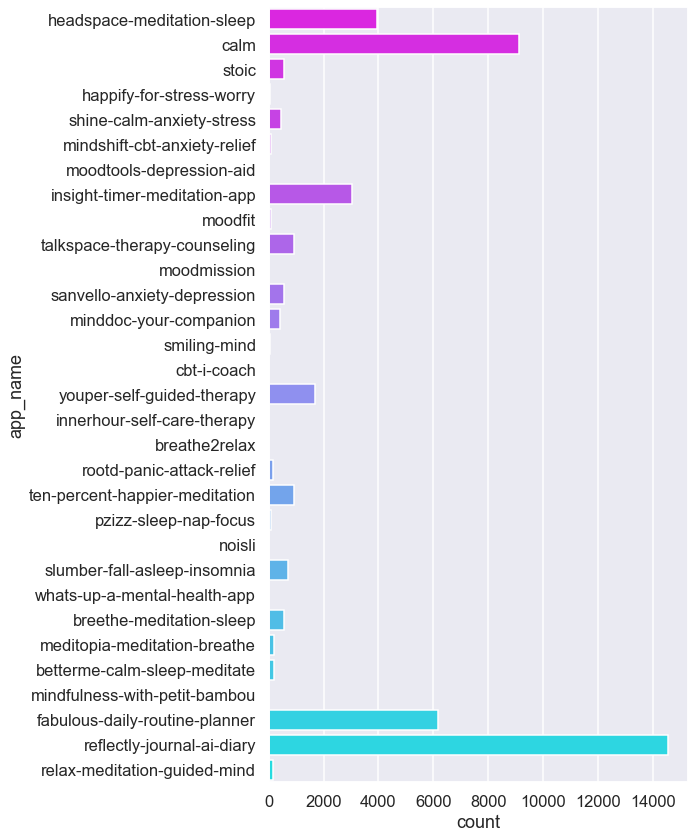

In [21]:
# Plot distribution of review count by app name
fig, ax = plt.subplots(figsize=(10,12))

sns.countplot(data=df, y='app_name', palette='cool_r', ax=ax, orient='h')
plt.tight_layout()

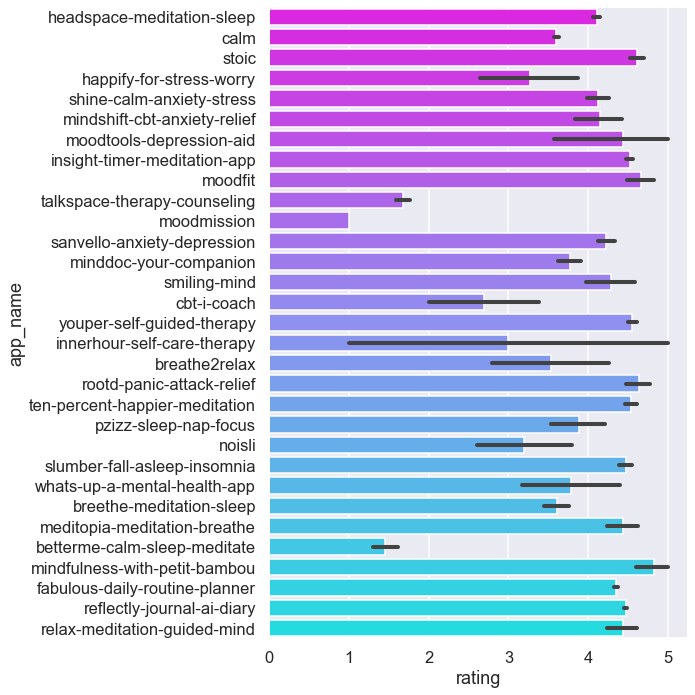

In [22]:
# Plot average rating by app name
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(data=df, x='rating', y='app_name', palette='cool_r', 
            ax=ax, orient='h')
plt.tight_layout()

In [23]:
# Check distribution of ratings across all apps
df['rating'].value_counts()

5    30534
1     5898
4     4058
3     2379
2     1829
Name: rating, dtype: int64

In [24]:
# Check distribution of ratings across all apps in percentages
df['rating'].value_counts(normalize=True)

5    0.683118
1    0.131952
4    0.090787
3    0.053224
2    0.040919
Name: rating, dtype: float64

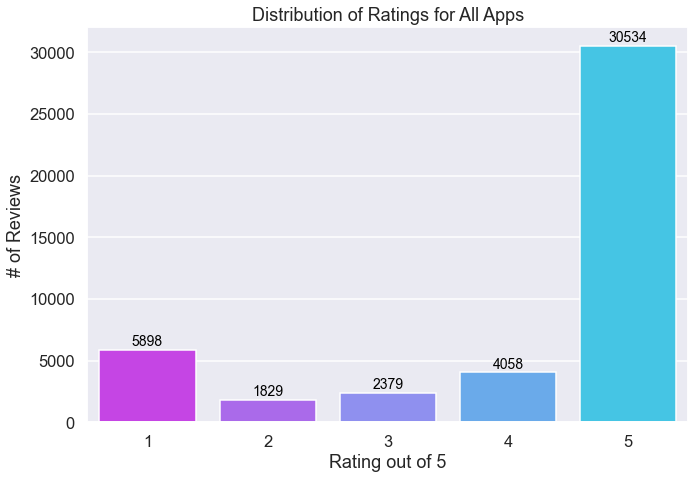

In [25]:
# Plot distribution of ratings across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='rating', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Ratings for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Rating out of 5')

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [28]:
# Create dataframe with data for top five apps in terms of review count
distribution_df = df[df['app_name'].isin(['headspace-meditation-sleep', 'calm',
                                          'insight-timer-meditation-app',
                                          'fabulous-daily-routine-planner',
                                          'reflectly-journal-ai-diary'])]

# Calculate average mean rating across top five apps
distribution_df = distribution_df.groupby('app_name')['rating']\
                                 .value_counts(normalize=True).to_frame()

# Rename percentage column and app_name column
distribution_df.columns = ['percentage']

# Reset index, rename app column and display result
distribution_df.reset_index(inplace=True)
distribution_df.columns = ['App', 'rating', 'percentage']
distribution_df

App  rating  percentage
0                             calm       5    0.527994
1                             calm       1    0.233154
2                             calm       4    0.084475
3                             calm       3    0.079873
4                             calm       2    0.074504
5   fabulous-daily-routine-planner       5    0.717134
6   fabulous-daily-routine-planner       4    0.124980
7   fabulous-daily-routine-planner       1    0.092884
8   fabulous-daily-routine-planner       3    0.036473
9   fabulous-daily-routine-planner       2    0.028530
10      headspace-meditation-sleep       5    0.670394
11      headspace-meditation-sleep       1    0.139771
12      headspace-meditation-sleep       4    0.084371
13      headspace-meditation-sleep       3    0.063532
14      headspace-meditation-sleep       2    0.041931
15    insight-timer-meditation-app       5    0.818994
16    insight-timer-meditation-app       1    0.069821
17    insight-timer-meditation-app       4    0.044672
18    insight-timer-meditation-app       3    0.038385
19    insight-timer-meditation-app       2    0.028127
20      reflectly-journal-ai-diary       5    0.761450
21      reflectly-journal-ai-diary       4    0.100941
22      reflectly-journal-ai-diary       1    0.064822
23      reflectly-journal-ai-diary       3    0.047037
24      reflectly-journal-ai-diary       2    0.025750

In [29]:
# Create map dictionary to format app names
app_name_map = {'calm': 'Calm',
                'fabulous-daily-routine-planner': 'Fabulous: Daily Routine Planner',
                'headspace-meditation-sleep': 'Headspace',
                'insight-timer-meditation-app': 'Insight Timer',
                'reflectly-journal-ai-diary': "Reflectly Journal & AI Diary"}

In [30]:
# Map unformatted app names to formatted app names and display
distribution_df['App'] = distribution_df['App'].map(app_name_map)
distribution_df

App  rating  percentage
0                              Calm       5    0.527994
1                              Calm       1    0.233154
2                              Calm       4    0.084475
3                              Calm       3    0.079873
4                              Calm       2    0.074504
5   Fabulous: Daily Routine Planner       5    0.717134
6   Fabulous: Daily Routine Planner       4    0.124980
7   Fabulous: Daily Routine Planner       1    0.092884
8   Fabulous: Daily Routine Planner       3    0.036473
9   Fabulous: Daily Routine Planner       2    0.028530
10                        Headspace       5    0.670394
11                        Headspace       1    0.139771
12                        Headspace       4    0.084371
13                        Headspace       3    0.063532
14                        Headspace       2    0.041931
15                    Insight Timer       5    0.818994
16                    Insight Timer       1    0.069821
17                    Insight Timer       4    0.044672
18                    Insight Timer       3    0.038385
19                    Insight Timer       2    0.028127
20     Reflectly Journal & AI Diary       5    0.761450
21     Reflectly Journal & AI Diary       4    0.100941
22     Reflectly Journal & AI Diary       1    0.064822
23     Reflectly Journal & AI Diary       3    0.047037
24     Reflectly Journal & AI Diary       2    0.025750

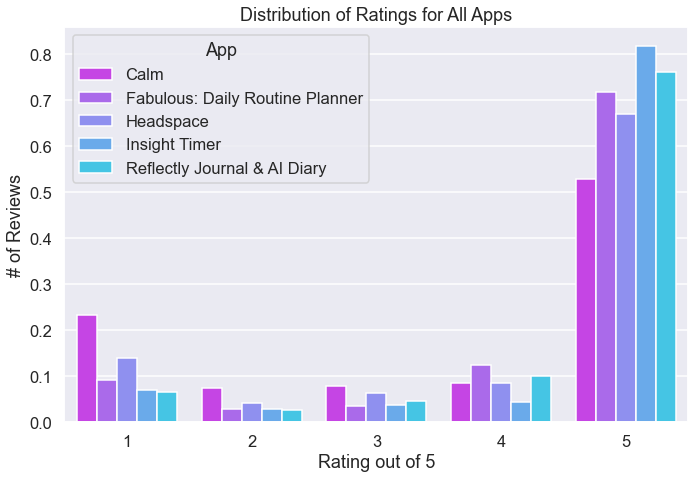

In [31]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,7))

# Create Barplot
sns.barplot(x='rating', y='percentage', hue='App', data=distribution_df, 
            ax=ax, palette='cool_r')

# Format barplot
ax.set_title('Distribution of Ratings for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Rating out of 5')
fig.tight_layout();

We can gather from the above plots that users are much more likely to leave positive 5-star ratings than they are to leave lower ratings and that the number of 1-star ratings is higher than ratings from 2-4 stars. We can also see that although there are some differences in distribution between apps, they generally follow a similar distribution of ratings.

### Target Engineering

Here, we will create our target variables based on the ratings given by app users. First, we begin with a multi-class sentiment target and then move onto a version of a binary sentiment target where 4 stars and above are considered to be positive, as well as an alternative version where 3 stars and above are positive.

#### Multi-Class Sentiments

In [30]:
# Make new multiclass sentiment column based on rating
# 4 and above are positive, 3 is neutral, 1-2 are negative
conditions = [df['rating'] >= 4,
              df['rating'] == 3,
              df['rating'] <= 2,]
values = [2, 1, 0]

df['multi_sent'] = np.select(conditions, values)

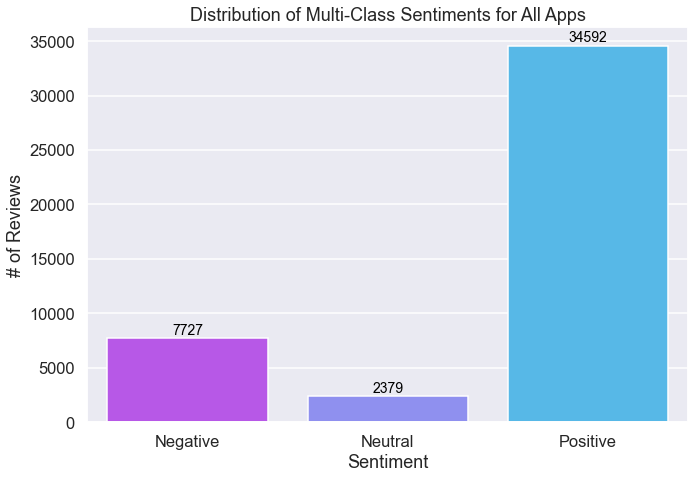

In [31]:
# Plot distribution of multiclass sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))

sns.countplot(x='multi_sent', data=df, ax=ax, palette='cool_r')

ax.set_title('Distribution of Multi-Class Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative','Neutral', 'Positive'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

#### Binary Sentiments

In [32]:
# Make new binary sentiment column based on ratings
# 3 and above are positive, below 3 is negative
conditions = [df['rating'] >= 3,
              df['rating'] < 3]

values = [1,0]

df['sent_bin_3up'] = np.select(conditions, values)

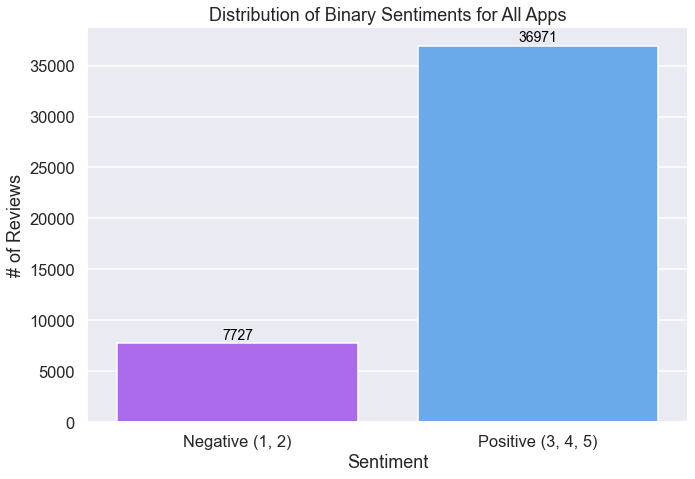

In [33]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_3up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1, 2)', 'Positive (3, 4, 5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [34]:
## Make new binary sentiment column based on ratings 4 and up
conditions = [
    df['rating'] >= 4,
    df['rating'] < 4,
]

values = [1,0]

df['sent_bin_4up'] = np.select(conditions, values)

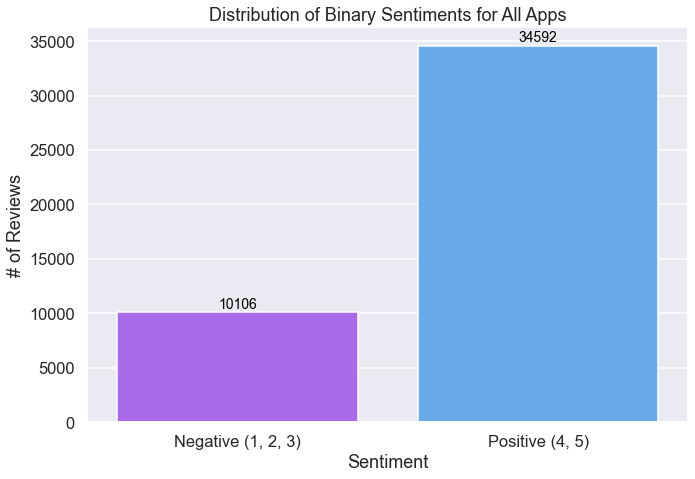

In [35]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_4up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1, 2, 3)', 'Positive (4, 5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

We can see a large class imbalance between Negative and Positive for both splits. However, during the modeling trials, it was found that the 1-3, 4-5 split performed slightly better than the 1-2, 3-5 split on all model types. Therefore, we will proceed with the 1-3, 4-5 split, since the insights we can gain from a more accurate model will be more powerful than from a less accurate one.

During the modeling phase, it will be important to keep in mind that there is a class imbalance for both our multi-class classification and our binary classification.

Now, let's slice out the columns relevant to our analysis and move onto preprocessing the actual text reviews.

In [36]:
# Slice out relevant columns into a new dataframe
clean_df = df[['date', 'userName', 'combined_text', 'rating', 'multi_sent', 
               'sent_bin_3up', 'sent_bin_4up']]
clean_df

date           userName  \
0      2021-02-22 18:13:54  Crazy Yorkie Lady   
1      2021-02-12 12:42:11           KLC-MHFL   
2      2021-02-11 06:22:38        Ashabashley   
3      2021-01-18 17:14:21           Kindly38   
4      2021-02-08 19:19:10          jlhuggins   
...                    ...                ...   
44717  2020-04-06 23:34:12            JLucret   
44718  2020-03-28 06:01:54          mata rato   
44719  2020-03-24 13:44:13        Fierce Girl   
44720  2020-03-07 17:29:09           Irkesome   
44721  2020-02-18 02:08:56           ksavv916   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                combined_text  \
0      This is the BEST app by far for mindfulness. It’s almost embarrassing to say this, but I have been a “meditator” for about 30 years and I have to say that I never really got very much out of doing it.  I tried so hard, but I’m finding out I never truly understood that “trying” to be a good meditator or mindful person, was missing what doing this was about.  What I’m learning through this app is that “mindfulness” is about me - understanding myself first, and it’s a lot about acceptance.  So with that understanding and acceptance I can begin to see “things” so much more clearly and why previous ways of thinking, particularly about myself, were holding me back from living my life and loving myself.  And I’m finding that the more I practice self acceptance, the fears about living fully and going after what I want out of my life, are disappearing.   The previous version of myself is rapidly becoming someone I only used to know, and this new ME is much more in line with who I’d always wanted to be.  I’m able to try and do so much more, all while in the comfort that I am lovable, even if I fail at something.  I simply dust myself off and try some more. This app has completely changed me and the way I’m able to appreciate all the good that’s in my life.  And I’m worthy of going after the things I want for my life, while freeing me up to share my gifts with others and society in general. If this is where you find your life stalling out, this app will bring you back to yourself.   
1                               Facing down the rabbit hole. I discovered Headspace on Netflix. My life is a series of invitations to succumb to fear. My husband is a practicing psychologist who is on peritoneal dialysis for 10 hours every night and works remotely with patients for about 10 hours every day without complaint. We have been waiting for a kidney for two years. I am optimistic by nature but even if this was 

## Tokenization

We begin by tokenizing our corpus. Since we do not have any strangely formatted text to worry about with app reviews, we will use the RegExp Tokenizer to tokenize any all words, including those abbreviated with apostrophes.

In [37]:
# Create a single corpus out of all combined text
corpus = clean_df['combined_text'].to_list()

# Convert Corpus to Tokens
tokens = regexp_tokenize(','.join(corpus), r"([a-zA-Z]+(?:’[a-z]+)?)")

# Preview tokens
tokens[:20]

['This',
 'is',
 'the',
 'BEST',
 'app',
 'by',
 'far',
 'for',
 'mindfulness',
 'It’s',
 'almost',
 'embarrassing',
 'to',
 'say',
 'this',
 'but',
 'I',
 'have',
 'been',
 'a']

In [38]:
# Check number of unique tokens
len(set(tokens))

28718

## Lemmatization

Next, we lemmatize our tokens to make sure that we are able to properly remove any stopwords later.

In [39]:
# Lemmatizing function for list of tokens
def lemmatize_tokens(tokens_list):
    """
    Lemmatizes list of string trokens and returns list of lemmatized
    string tokens.

    Args:
        tokens_list (list) : List of string tokens to be lemmatized.

    Returns:
        tokens_lemm (list) : List of lemmatized string tokens
    """
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemm = [lemmatizer.lemmatize(word) for word in tokens_list]
    return tokens_lemm

In [40]:
# Lemmatize tokens
nltk.download('wordnet')
lemmatized_tokens = lemmatize_tokens(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# Check number of unique tokens after lemmatization
len(set(lemmatized_tokens))

26678

Our lemmatization function has reduced the number of unique tokens by a little over 2000 words.

## Stopword Removal

We can now remove any stopwords that are cluttering our text reviews to prevent us from extracting words that have more value towards determining the user sentiments.

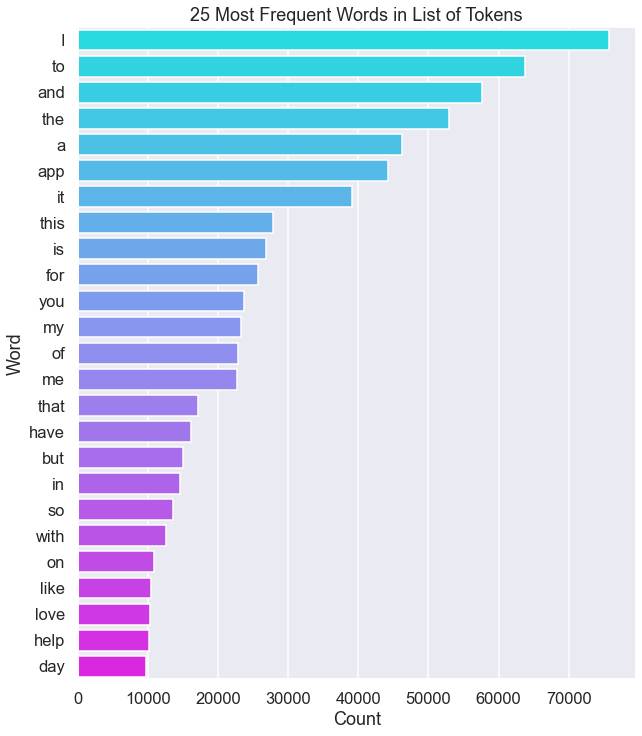

In [42]:
# Write function to create barplot of most common words
def most_freq(tokens, n=25, figsize=(12,7)):
    """
    Displays bar plot of n most frequent words in a list of tokens.

    Args:
        tokens (list) : List of string tokens to plot frequency for.
        n (int) : Number of tokens to plot.
        figsize (float, float) : Width, height in inches.

    Returns:
        
    """
    # Get frequency distribution of list of tokens
    freq = FreqDist(tokens)
    
    # Convert to DataFrame
    most_frequent_tokens = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count', 
                                                                 ascending=False)

    # Plot frequency distribution
    fig, ax = plt.subplots(figsize=(10,12))
    
    sns.barplot(data=most_frequent_tokens, y='word', x='count', 
                palette='cool', ax=ax, orient='h')

    ax.set_title(f'{n} Most Frequent Words in List of Tokens')
    ax.set_ylabel('Word')
    ax.set_xlabel('Count')
    
    
# Display frequency distirbution of lemmatized tokens
most_freq(lemmatized_tokens)

In [43]:
# Get all the stop words in the English language and preview first 25
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list[:25]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [44]:
# Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)
stopwords_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [45]:
# Add additional punctuation below to stopwords_list
stopwords_list.extend(['“','”','...',"''",'’','``'])

In [46]:
# Remove stopwords from list of tokens
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['best',
 'app',
 'far',
 'mindfulness',
 'it’s',
 'almost',
 'embarrassing',
 'say',
 'meditator',
 'year',
 'say',
 'never',
 'really',
 'got',
 'much',
 'tried',
 'hard',
 'i’m',
 'finding',
 'never',
 'truly',
 'understood',
 'trying',
 'good',
 'meditator',
 'mindful',
 'person',
 'wa',
 'missing',
 'wa',
 'i’m',
 'learning',
 'app',
 'mindfulness',
 'understanding',
 'first',
 'it’s',
 'lot',
 'acceptance',
 'understanding',
 'acceptance',
 'begin',
 'see',
 'thing',
 'much',
 'clearly',
 'previous',
 'way',
 'thinking',
 'particularly']

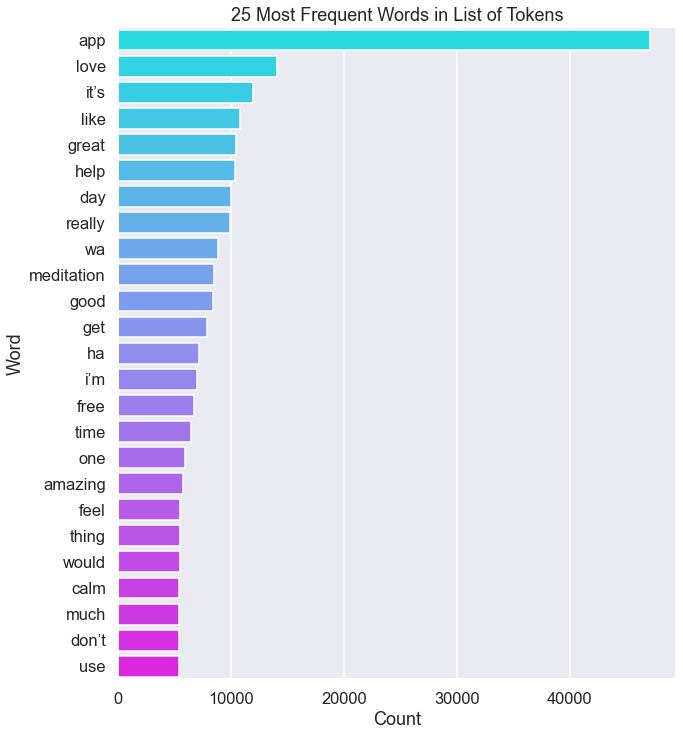

In [47]:
# Display frequency distirbution of lemmatized tokens after removing stopwords
most_freq(stopped_tokens, 25, figsize=(12,40))

Now that we have removed common stopwords, we begin to see more insightful words. However, we can continue to remove some words that provide no value toward differentiating between negative, positive and neutral sentiments, including the word "app" and the common app names.

In [48]:
# Add common words unrelated to sentiment to stopwords_list
stopwords_list.extend(["app","wa", "ha", "apps", "headspace", "calm", 
                       "insight", "timer", "fabulous", "reflectly"])

In [49]:
# Remove new stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]
stopped_tokens[:50]

['best',
 'far',
 'mindfulness',
 'it’s',
 'almost',
 'embarrassing',
 'say',
 'meditator',
 'year',
 'say',
 'never',
 'really',
 'got',
 'much',
 'tried',
 'hard',
 'i’m',
 'finding',
 'never',
 'truly',
 'understood',
 'trying',
 'good',
 'meditator',
 'mindful',
 'person',
 'missing',
 'i’m',
 'learning',
 'mindfulness',
 'understanding',
 'first',
 'it’s',
 'lot',
 'acceptance',
 'understanding',
 'acceptance',
 'begin',
 'see',
 'thing',
 'much',
 'clearly',
 'previous',
 'way',
 'thinking',
 'particularly',
 'holding',
 'back',
 'living',
 'life']

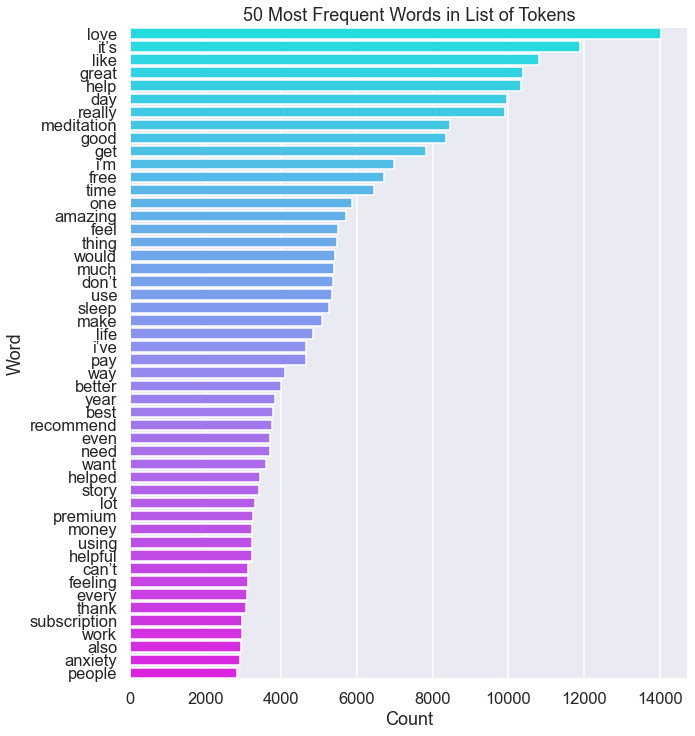

In [50]:
# Display list of tokens after removing extended stopwords
most_freq(stopped_tokens,50, figsize=(12,25))

The words that we have left are much more insightful, but we also want to remove words that are too indicative of the user's sentiment. By doing so, we will be able to better examine what elements of the apps users considered to be negative or positive without obvious indicator words.

The words that are added to the stopword list here have been determined after an initial iteration of the modeling process, where obvious words were taking away from our insights regarding app characteristics.

In [51]:
# Add obvious indicator words to stopwords list
stopwords_list.extend(["good", "love", "best", "amazing", "great", "awesome",
                       "perfect", "fabulous", "wonderful", "excellent", 
                       "helps", "helped", "helpful", "helping", "loving", 
                       "beautiful", "favorite", "fantastic", "calm", "good", 
                       "nice", "stupid", "annoying", "hate", "awful", "worse", 
                       "worst", "terrible", "disappointed", "disappointing", 
                       "garbage", "recommend", "thanks", "thank", "horrible", 
                       "like", "it's", "i'm", "really", "like", "bad"])

In [52]:
# Remove stopwords
stopped_tokens = [w.lower() for w in lemmatized_tokens  if w.lower() \
                  not in stopwords_list]

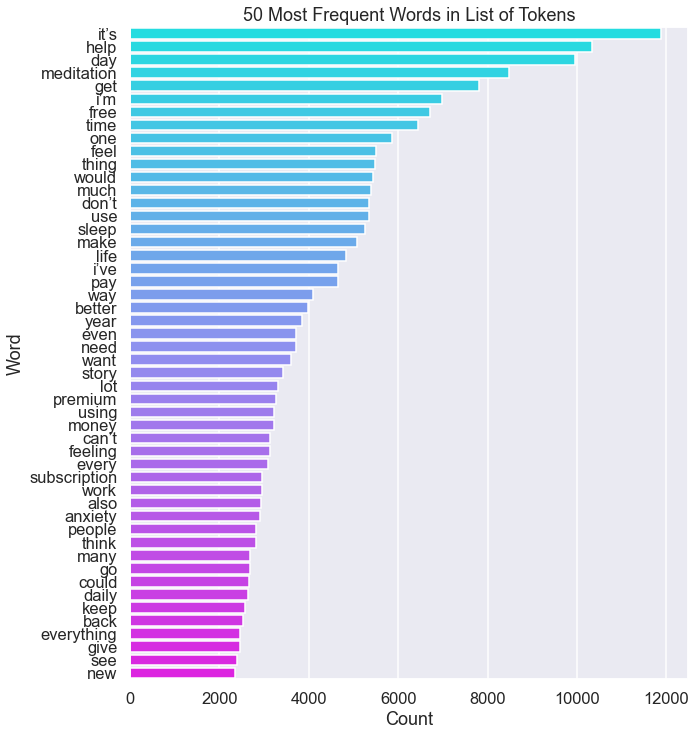

In [53]:
# Display frequency distribution of clean list of tokens
most_freq(stopped_tokens,50, figsize=(12,25))

## Bigram Exploration
Here, we will briefly look at whether there might be combinations of words that might give us more insight into sentiment than single words.

In [54]:
# Get bigrams and frequencies from list of stopped tokens
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
bigram_scores = bigram_finder.score_ngrams(bigram_measures.raw_freq)

In [55]:
# Make a DataFrame from the bigram frequencies
pd.DataFrame(bigram_scores, columns=["Word","Freq"]).head(20)

Word      Freq
0       (mental, health)  0.001453
1         (fall, asleep)  0.001265
2          (free, trial)  0.001090
3         (sleep, story)  0.001057
4           (make, feel)  0.001053
5           (every, day)  0.000933
6   (guided, meditation)  0.000902
7       (life, changing)  0.000694
8            (easy, use)  0.000680
9         (feel, better)  0.000658
10       (free, version)  0.000649
11         (i’ve, using)  0.000646
12   (customer, service)  0.000643
13           (help, lot)  0.000623
14           (help, get)  0.000604
15         (don’t, want)  0.000596
16        (every, night)  0.000579
17         (don’t, know)  0.000536
18         (keep, track)  0.000527
19         (help, sleep)  0.000518

It's clear that there are some quite insightful combinations of words. Sleep seems to be a recurring topic in these bigrams, and we can begin to see that this is one element of a mental health app that we would want to consider allocating resources toward developing. Because bigrams have been seen to be insightful, we will keep note of this as we approach the modeling phase.

Let's move on to examine whether Pointwise Mutual Information scores of our bigrams reveal any insight.

In [56]:
# Get bigrams and PMI scores from list of stopped tokens
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
bigram_pmi_finder.apply_freq_filter(3)
bigram_pmi_scored = bigram_pmi_finder.score_ngrams(bigram_measures.pmi)

In [57]:
# Make a DataFrame from the bigram PMI scores
pd.DataFrame(bigram_pmi_scored,columns=['Words','PMI']).head(20)

Words        PMI
0         (mumbo, jumbo)  18.042860
1          (suze, orman)  18.042860
2      (ellie, goulding)  17.627822
3       (gregg, mcbride)  17.627822
4          (idris, elba)  17.627822
5        (jerome, flynn)  17.627822
6          (kabat, zinn)  17.627822
7       (nick, offerman)  17.627822
8    (alice, wonderland)  17.305894
9      (kenneth, soares)  17.305894
10     (roller, coaster)  17.305894
11           (tel, fono)  17.305894
12      (united, states)  17.305894
13        (winnie, pooh)  17.305894
14          (meow, meow)  17.212785
15         (tk, kellman)  17.212785
16       (civil, unrest)  17.042860
17  (sponsored, grubhub)  17.042860
18        (naomi, osaka)  17.042860
19    (marcus, aurelius)  16.890857

Compared to bigram frequencies, PMI scores do not appear to offer much additional insight.

Let's move on to creating wordclouds for our different sentiments.

## WordCloud Visualization
At this point, we have all the parts we need in order to clean up a corpus and create a wordcloud. By creating a wordcloud, we can easily visualize what words are associated with certain sentiments.

Let's begin by previewing a wordcloud for all reviews, with only our final list of stopwords removed.

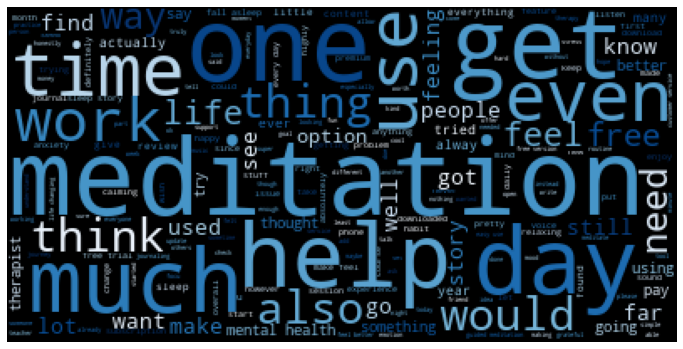

In [58]:
# Create a WordCloud with our stopwords_list and include bigrams
wordcloud = WordCloud(stopwords=stopwords_list,collocations=True, 
                      colormap='Blues', background_color="Black")

# Generate wordcloud from stopped_tokens
wordcloud.generate(','.join(stopped_tokens))

# Plot with matplotlib
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off');

This wordcloud provides us with words that are commonly mentioned in reviews, but it doesn't really tell us much about the sentiments.

In order to get a better idea of what words are associated with different sentiments, we will need to create a few different DataFrames.

### Preparing for WordCloud Generation

In [59]:
# Create and display DataFrames for multi-class sentiments
multi_pos_df = clean_df[clean_df['multi_sent']==2]
multi_neut_df = clean_df[clean_df['multi_sent']==1]
multi_neg_df = clean_df[clean_df['multi_sent']==0]
display(multi_neg_df, multi_neut_df, multi_pos_df)

date               userName  \
52     2021-07-02 13:40:31            DWil9059230   
58     2020-08-09 12:42:14            njalexsmith   
60     2020-02-17 08:00:14    Carpeltunneltexting   
72     2020-02-28 12:07:04             jamesui111   
81     2020-09-02 12:53:54               steveo74   
...                    ...                    ...   
44684  2021-02-27 14:24:58                 Tfeldy   
44686  2020-12-13 04:15:44             noodle1188   
44703  2020-05-20 05:16:44  Smileysmilessometimes   
44720  2020-03-07 17:29:09               Irkesome   
44721  2020-02-18 02:08:56               ksavv916   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       combined_text  \
52                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Meditation should transcend politics. This app has a lot of traditionally based vipassana-style meditation, which is very helpful for learning to meditate and gaining its benefits. However, the app has recently uploaded a lot of political content directly supporting movements such as Black Lives Matter and the ideology of critical race theory. It’s hard to emphasize enough how disastrous of a decision this is. It is reducing the transcendent method of meditation to a mere ideological political tool. M

date               userName  \
10     2021-01-15 15:44:26            zigalellium   
16     2021-06-09 05:06:38          Antiduplicity   
23     2021-06-27 15:56:22             odd numbet   
26     2021-06-09 05:23:23              Drnkdrrck   
39     2021-05-06 17:27:37        whatnickname256   
...                    ...                    ...   
44579  2020-02-22 18:10:33                Lithmac   
44589  2020-04-04 19:42:41                    🐖🐫🐪   
44602  2020-02-14 03:52:19           Papa's apple   
44624  2020-05-26 19:55:30         J4m3$rawdogger   
44671  2020-06-17 03:12:20  the real body of rage   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            combined_text  \
10                          Great resource!. This is really helpful! The only reason I didn’t give a higher rating is because there’s a strong overlying tone of a sales pitch there. Which is unfortunate, because I think people would be able to see the value easier if there wasn’t a push for money after every meditation and for many of the things on the app people would want to explore. Kind of stalls progress of the meditation itself when you’ve just worked so hard to pull yourself back, only to be instantly asked for money right after. From a company stand point I also think it would be more beneficial to work on building value and then freely offering the option to see what monthly costs are and also show a detailed description of what’s involved with a paid membership. I know this has worked well financially for other services and I’ve seen increases in sales by simply looking at things from the customers perspective. And I feel like the customers perspective is a miss here :( However quite and easy fix and overall this app is amazing! It not only teaches the basics of meditation, but teaches different techniques as well. This makes it good for beginners all the way to experts. I truly believe that the basis of this app is pure in intention and I can see what a help it is to many people who walk the path of life.   
16     A great app.  Needs work. I give this app 5 stars because the build of this app, the contents of this app, the flow of this app is great. well done. Every app can be improved and this one needs work in some ways 1. the watch app: the only thing I every get on the watch app is a 1 minute "breath mini". the watch app is basically useless. Why can't I see my today screen on the watch and start my various mediations from the watch. the watch app gets 1 star. 2. Shortcuts: on the iphone I have setup a sleep schedule. On the "good night" screen I am given the option to run shortcuts. Headspace offers a few shortcuts that can be called from this screen. One is the nightly "sleepcast". the sleep

date           userName  \
0      2021-02-22 18:13:54  Crazy Yorkie Lady   
1      2021-02-12 12:42:11           KLC-MHFL   
2      2021-02-11 06:22:38        Ashabashley   
3      2021-01-18 17:14:21           Kindly38   
4      2021-02-08 19:19:10          jlhuggins   
...                    ...                ...   
44715  2020-05-05 14:01:25        Randy191987   
44716  2020-05-04 21:18:00            Mlpk182   
44717  2020-04-06 23:34:12            JLucret   
44718  2020-03-28 06:01:54          mata rato   
44719  2020-03-24 13:44:13        Fierce Girl   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                combined_text  \
0      This is the BEST app by far for mindfulness. It’s almost embarrassing to say this, but I have been a “meditator” for about 30 years and I have to say that I never really got very much out of doing it.  I tried so hard, but I’m finding out I never truly understood that “trying” to be a good meditator or mindful person, was missing what doing this was about.  What I’m learning through this app is that “mindfulness” is about me - understanding myself first, and it’s a lot about acceptance.  So with that understanding and acceptance I can begin to see “things” so much more clearly and why previous ways of thinking, particularly about myself, were holding me back from living my life and loving myself.  And I’m finding that the more I practice self acceptance, the fears about living fully and going after what I want out of my life, are disappearing.   The previous version of myself is rapidly becoming someone I only used to know, and this new ME is much more in line with who I’d always wanted to be.  I’m able to try and do so much more, all while in the comfort that I am lovable, even if I fail at something.  I simply dust myself off and try some more. This app has completely changed me and the way I’m able to appreciate all the good that’s in my life.  And I’m worthy of going after the things I want for my life, while freeing me up to share my gifts with others and society in general. If this is where you find your life stalling out, this app will bring you back to yourself.   
1                               Facing down the rabbit hole. I discovered Headspace on Netflix. My life is a series of invitations to succumb to fear. My husband is a practicing psychologist who is on peritoneal dialysis for 10 hours every night and works remotely with patients for about 10 hours every day without complaint. We have been waiting for a kidney for two years. I am optimistic by nature but even if this was 

In [60]:
# Create and display DataFrames for binary sentiments
bin_pos_df = clean_df[clean_df['sent_bin_4up']==1]
bin_neg_df = clean_df[clean_df['sent_bin_4up']==0]
display(bin_neg_df, bin_pos_df)

date               userName  \
10     2021-01-15 15:44:26            zigalellium   
16     2021-06-09 05:06:38          Antiduplicity   
23     2021-06-27 15:56:22             odd numbet   
26     2021-06-09 05:23:23              Drnkdrrck   
39     2021-05-06 17:27:37        whatnickname256   
...                    ...                    ...   
44684  2021-02-27 14:24:58                 Tfeldy   
44686  2020-12-13 04:15:44             noodle1188   
44703  2020-05-20 05:16:44  Smileysmilessometimes   
44720  2020-03-07 17:29:09               Irkesome   
44721  2020-02-18 02:08:56               ksavv916   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       combined_text  \
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Great resource!. This is really helpful! The only reason I didn’t give a higher rating is because there’s a strong overlying tone of a sales pitch there. Which is unfortunate, because I think people would be able to see the value easier if there wasn’t a push for money after every meditation and for many of the things on the app people would want to explore. Kind of stalls progress of the meditation itself when you’ve just worked so hard to pull yourself back, only to be instantly asked for money right after. From a company stand point I also think

date           userName  \
0      2021-02-22 18:13:54  Crazy Yorkie Lady   
1      2021-02-12 12:42:11           KLC-MHFL   
2      2021-02-11 06:22:38        Ashabashley   
3      2021-01-18 17:14:21           Kindly38   
4      2021-02-08 19:19:10          jlhuggins   
...                    ...                ...   
44715  2020-05-05 14:01:25        Randy191987   
44716  2020-05-04 21:18:00            Mlpk182   
44717  2020-04-06 23:34:12            JLucret   
44718  2020-03-28 06:01:54          mata rato   
44719  2020-03-24 13:44:13        Fierce Girl   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                combined_text  \
0      This is the BEST app by far for mindfulness. It’s almost embarrassing to say this, but I have been a “meditator” for about 30 years and I have to say that I never really got very much out of doing it.  I tried so hard, but I’m finding out I never truly understood that “trying” to be a good meditator or mindful person, was missing what doing this was about.  What I’m learning through this app is that “mindfulness” is about me - understanding myself first, and it’s a lot about acceptance.  So with that understanding and acceptance I can begin to see “things” so much more clearly and why previous ways of thinking, particularly about myself, were holding me back from living my life and loving myself.  And I’m finding that the more I practice self acceptance, the fears about living fully and going after what I want out of my life, are disappearing.   The previous version of myself is rapidly becoming someone I only used to know, and this new ME is much more in line with who I’d always wanted to be.  I’m able to try and do so much more, all while in the comfort that I am lovable, even if I fail at something.  I simply dust myself off and try some more. This app has completely changed me and the way I’m able to appreciate all the good that’s in my life.  And I’m worthy of going after the things I want for my life, while freeing me up to share my gifts with others and society in general. If this is where you find your life stalling out, this app will bring you back to yourself.   
1                               Facing down the rabbit hole. I discovered Headspace on Netflix. My life is a series of invitations to succumb to fear. My husband is a practicing psychologist who is on peritoneal dialysis for 10 hours every night and works remotely with patients for about 10 hours every day without complaint. We have been waiting for a kidney for two years. I am optimistic by nature but even if this was 

In [61]:
# Get image file to use for wordcloud mask
urllib.request.urlretrieve(
  'https://github.com/ds-leehanjin/dsc-capstone-project/blob/master/images/meditating_girl.png?raw=true',
   "meditating_girl.png")

# Create wordcloud mask
mask = np.array(Image.open('meditating_girl.png'))

In [62]:
# Write functions to use to create wordclouds
def wordcloud_prep(df_col, stopwords):
    """
    Converts a column of strings into a list of lemmatized tokens with
    a specified list of stopwords removed.

    Args:
        df_col (col) : Sliced column from dataframe with text to be put into
                       a wordcloud
        stopwords (list) : List of stopwords to remove from text.

    Returns:
        stopped_cloud (list) : List of lemmatized tokens with stopwords
                               removed.
    """
    
    # Tokenize and lemmatize corpus into tokens
    cloud_corpus = df_col.to_list()
    cloud_tokens = regexp_tokenize(','.join(cloud_corpus), 
                                   r"([a-zA-Z]+(?:’[a-z]+)?)")
    lemmatized_cloud = lemmatize_tokens(cloud_tokens)

    # Remove specified stopwords
    stopped_cloud = [w.lower() for w in lemmatized_cloud  if w.lower() \
                     not in stopwords]
    return stopped_cloud


def generate_wordcloud(tokens, stopwords=None, collocations=False, 
                       background_color='black', colormap='cool',
                       contour_color='steelblue',
                       mask=mask):
    """
    Creates and displays a wordcloud using the specified list of tokens,
    stopwords, and mask image.

    Args:
        tokens (list) : List of tokens to generate wordcloud from.
        stopwords (list) : List of stopwords to remove from text.
        collocations (bool) : Whether to include collocations (bigrams) of 
                              two words.
        background_color (color value) : Background color for the wordcloud image.
        colormap (matplotlib colormap) : Matplotlib colormap to randomly draw 
                                         colors from for each word.
        contour_color : Mask contour color.
        mask (nd-array) : Gives a binary mask on where to draw words. If mask 
                          is not None, width and height will be ignored and 
                          the shape of mask will be used instead.

    Returns:
        wordcloud : Image of wordcloud generated using specified text.
    """
    
    # Initalize a WordCloud
    wordcloud = WordCloud(stopwords = stopwords,
                          collocations=collocations, 
                          background_color=background_color, 
                          colormap=colormap,
                          mask=mask,contour_width=2, 
                          contour_color=contour_color,
                          min_font_size=15)

    # Generate wordcloud from tokens
    wordcloud.generate(','.join(tokens))

    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis('off');
    return wordcloud

### Multi-Class Sentiment WordClouds

Now, let's put everything together to generate some wordclouds on our multi-class sentiments.

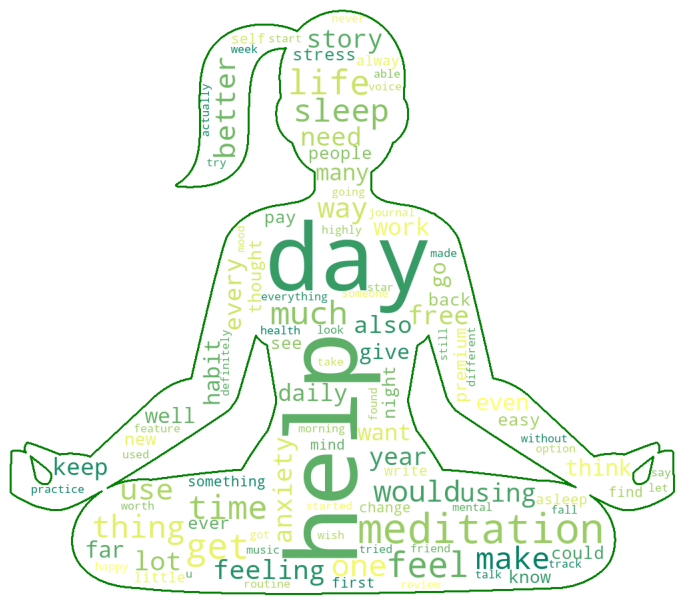

In [63]:
# Generate positive wordcloud for multi-class sentiment
multi_pos_tokens = wordcloud_prep(multi_pos_df['combined_text'], stopwords_list)
multi_pos_wc = generate_wordcloud(multi_pos_tokens, stopwords_list, 
                                  colormap='summer', background_color='white', 
                                  contour_color='green')

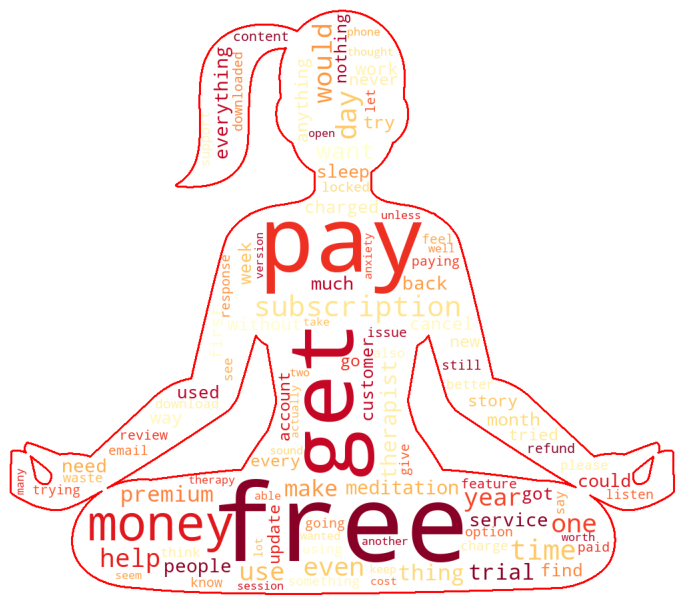

In [64]:
# Generate negative wordcloud for multi-class sentiment
multi_neg_tokens = wordcloud_prep(multi_neg_df['combined_text'], stopwords_list)
multi_neg_wc = generate_wordcloud(multi_neg_tokens, stopwords_list, 
                                  colormap='YlOrRd', background_color='white', 
                                  contour_color='red')

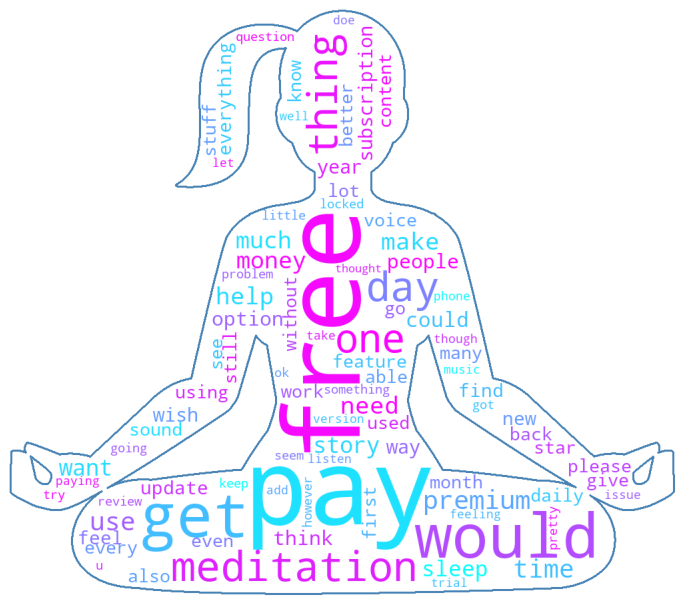

In [65]:
# Generate neutral wordcloud for multi-class sentiment
multi_neut_tokens = wordcloud_prep(multi_neut_df['combined_text'], 
                                   stopwords_list)
multi_neut_wc = generate_wordcloud(multi_neut_tokens, stopwords_list, 
                                   colormap='cool', background_color='white')

The positive and neutral wordclouds that we see above indicate that there are a variety of topics that users write about in their reviews. Note that we can see sleep again seems to be one of the more important topics for neutral and positive reviews. However, it's much more obvious for the negative wordcloud that the majority of dissatisfaction that users have is either payment or customer-support related.

### Binary Sentiment WordClouds
Let's take a look at whether our results differ when we split our data into two classes as opposed to three.

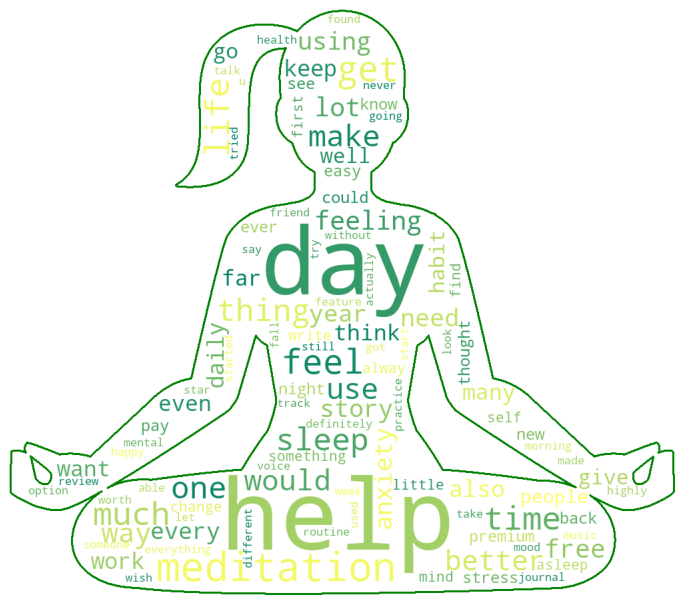

In [66]:
# Generate positive wordcloud for binary sentiment
bin_pos_tokens = wordcloud_prep(bin_pos_df['combined_text'], stopwords_list)
bin_pos_wc = generate_wordcloud(bin_pos_tokens, stopwords_list, 
                                colormap='summer', background_color='white', 
                                contour_color='green')

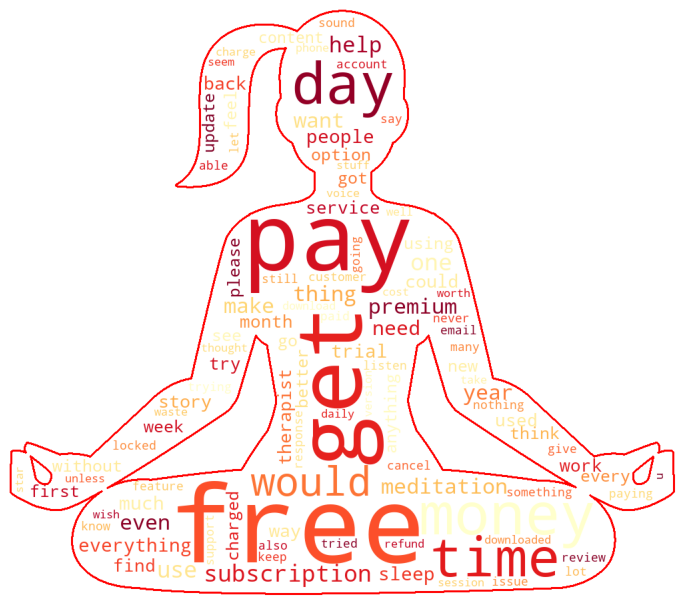

In [67]:
# Generate negative wordcloud for binary sentiment
bin_neg_tokens = wordcloud_prep(bin_neg_df['combined_text'], stopwords_list)
bin_neg_wc = generate_wordcloud(bin_neg_tokens, stopwords_list, 
                                colormap='YlOrRd', background_color='white', 
                                contour_color='red')

Again, we can see that our negative wordcloud contains lots of payment and customer-support related topics, but our positive wordcloud doesn't as clearly tell us what app features users appreciated. Not to worry though, since our modeling and interpretation should give us more accurate insight into what is considered positive or negative.

# MODEL

During this phase, we will explore some different modeling algorithms to help us extract more accurate insights into what words are more influential in classifying sentiments.

For multi-class sentiments, we will explore Logistic Regression and Random Forest models. For binary sentiments, we will add Support Vector Classification, and where necessary, we will implement a gridsearch to optimize model performance and address the issue of under or overfitting to the training data.

As we saw during the Exploratory Data Analysis, there is a class imbalance for both the multi-class and binary data, and so we will set the class weight of all models to "balanced". 

Since we saw that bigrams can reveal additional insight, we will also set our ngram_range to (1,2) to include vectorization of individual words as well as bigrams.

In [68]:
# Model evaluation function
def evaluate_model(y_test, y_train, X_test, X_train, clf, n_class=3, 
                   figsize=(10,5), digits=2, params=False):
    """
    Displays evaluation metrics including classification report, confusion
    matrix, ROC-AUC curve.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        y_test (Series) : Testing data with target variable.
        y_train (Series) : Training data with target variable.
        X_test (DataFrame) : Testing data with vectorized feature variables.
        X_train (DataFrame) : Training data with vectorized feature variables.
        clf (classifier object) : Type of classificatier model to use.
        n_class (int) : Number of classes for classification task.
        figsize (int, int) : Figure dimensions. Default is (10,5)
        digits (int) : Number of decimal places to display in classification
                       report
        params (bool) : Prints table of hyperparameters used in model.
        
    Returns:
    
    """

    sns.set_style('dark')

    # Get Predictions
    y_hat_test = clf.predict(X_test)
    
    # Display training and test accuracy
    print("****TRAIN VS TEST ACCURACY****")
    print("\n", f"Training Score: {round(clf.score(X_train, y_train),2)}", 
          "\n", f"Test Score: {round(clf.score(X_test, y_test),2)}", "\n")
    
    # Display classification report
    print("****CLASSIFICATION REPORT - TEST DATA****")
    print(metrics.classification_report(y_test, y_hat_test, digits=digits))
    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")
    
    if n_class == 3:
        # Create a figure/axes for confusion matrix and ROC curve
        fig, ax = plt.subplots(ncols=2, figsize=figsize)

        # Plot confusion matrix
        plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test, 
                              cmap='Purples', normalize='true', ax=ax[0], 
                              display_labels=['Negative', 'Neutral', 
                                              'Positive'])
        ax[0].set_title('Confusion Matrix')
        
        # Plot ROC-AUC curve
        pred_prob = clf.predict_proba(X_test)
        fpr={}
        tpr={}
        thresh={}

        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], 
                                                  pos_label=i)
            
        ax = ax[1]
        ax.grid()
        ax.plot(fpr[0], tpr[0], linestyle='-',color='red', label='Negative')
        ax.plot(fpr[1], tpr[1], linestyle='-',color='blue', label='Neutral')
        ax.plot(fpr[2], tpr[2], linestyle='-',color='green', label='Positive')
        ax.set_title('ROC-AUC curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.legend(loc='best')
        ax.plot([0,1], [0,1], ls='-', color='purple')

        plt.tight_layout()
        plt.show()

    elif n_class == 2:
        fig, axes = plt.subplots(ncols=2, 
                                 figsize=figsize)

        # Plot confusion matrix
        metrics.plot_confusion_matrix(clf, X_test,
                                      y_test,normalize='true',
                                      cmap='Purples',ax=axes[0],
                                      display_labels=['Negative', 'Positive'])
        axes[0].set_title('Confusion Matrix')

        # Plot ROC-AUC curve
        metrics.plot_roc_curve(clf,X_test,y_test,ax=axes[1])

        ax = axes[1]
        ax.plot([0,1],[0,1], ls='-', color='purple')
        ax.grid()
        ax.set_title('ROC-AUC Curve')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive rate')
        ax.get_legend().remove()

        plt.tight_layout()
        plt.show()
        
    # Print model parameters
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(clf.get_params()))
        params.columns=['parameters']
        display(params)

## Multi-Class Modeling: [1-2] Negative, [3] Neutral, [4-5] Positive

### Vectorizing Train-Test Splits
We begin the modeling process by creating an X and y train-test split and then using a TF-IDF vectorizer to preprocess each document.

In [69]:
# Make X and y
y_multi = clean_df['multi_sent'].copy()
X = clean_df['combined_text'].copy()

# Train Test Split
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X, y_multi, 
                                                                            test_size=0.3, 
                                                                            random_state=27)

# Check y_train value counts
y_multi_train.value_counts(normalize=True)

2    0.774930
0    0.171951
1    0.053119
Name: multi_sent, dtype: float64

In [70]:
# Initialize RegExp tokenizer
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

# Make a TF-IDF vectorizer
vectorizer_multi = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                   token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                   stop_words=stopwords_list,
                                   ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_multi_train_tfidf = vectorizer_multi.fit_transform(X_multi_train)
X_multi_test_tfidf = vectorizer_multi.transform(X_multi_test)
X_multi_train_tfidf

<31288x310249 sparse matrix of type '<class 'numpy.float64'>'
	with 1030078 stored elements in Compressed Sparse Row format>

### Logistic Regression
We are now ready to fit our first model using a Logistic Regression algorithm on our multi-class data. Due to hardware limitations as well as the fact that we will later see better performing models, we will omit the gridsearch phase for this particular model.

In [71]:
# Fit Logistic Regression model on multi-class training data
logreg = LogisticRegression(max_iter=200, class_weight='balanced')
logreg.fit(X_multi_train_tfidf, y_multi_train)

LogisticRegression(class_weight='balanced', max_iter=200)

****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2347
           1       0.23      0.39      0.29       717
           2       0.96      0.89      0.92     10346

    accuracy                           0.85     13410
   macro avg       0.64      0.69      0.66     13410
weighted avg       0.88      0.85      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


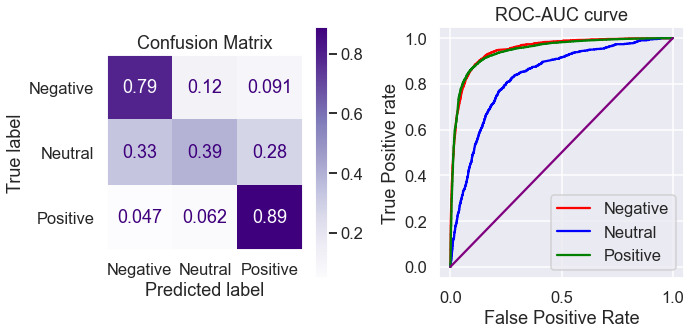

In [72]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, logreg)

Even without the help of a gridsearch, our Logistic Regression model already seems to have decent performance when it comes to classifying negative and positive sentiments. It does have much poorer performance classifying neutral sentiments, but this is understandable considering that the neutral sentiment wordcloud was also not able to give us much insight into what topics were associated with a neutral sentiment.

### Random Forest

In [73]:
# Fit Random Forest model on multi-class training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_multi_train_tfidf, y_multi_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.88      0.44      0.59      2347
           1       0.50      0.00      0.01       717
           2       0.84      0.99      0.91     10346

    accuracy                           0.84     13410
   macro avg       0.74      0.48      0.50     13410
weighted avg       0.83      0.84      0.81     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


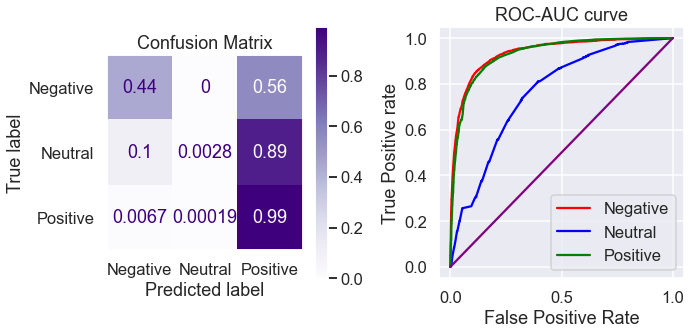

In [74]:
# Evaluate model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, rf)

On our first iteration of a Random Forest model, we can see that the model is clearly being overfit to the training data, resulting in extremely poor recall scores for negative and neutral sentiments. Let's use a gridsearch to address this issue.

In [75]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [10, 20, 40],
              'n_estimators': [50, 100, 200],
              'min_samples_leaf': [2, 5, 10]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_multi_train_tfidf,  y_multi_train)
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'min_samples_leaf': 2,
 'n_estimators': 200}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.87 
 Test Score: 0.84 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      2347
           1       0.22      0.25      0.24       717
           2       0.91      0.92      0.91     10346

    accuracy                           0.84     13410
   macro avg       0.62      0.61      0.61     13410
weighted avg       0.84      0.84      0.84     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


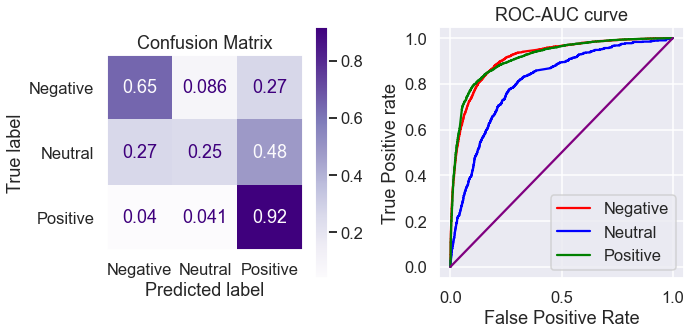

In [76]:
# Evaluate best model performance
evaluate_model(y_multi_test, y_multi_train, X_multi_test_tfidf, 
               X_multi_train_tfidf, gridsearch.best_estimator_)

Our gridsearched model's performance has improved considerably in classifying negative and neutral sentiments, but it still isn't quite ideal. Let's see if running another gridsearch can further improve performance.

In [77]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['entropy'],
              'max_depth': [40, 60],
              'n_estimators': [200, 300],
              'min_samples_leaf': [5]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_multi_train_tfidf,  y_multi_train)
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 60,
 'min_samples_leaf': 5,
 'n_estimators': 300}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.84 
 Test Score: 0.82 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      2347
           1       0.21      0.38      0.27       717
           2       0.92      0.89      0.91     10346

    accuracy                           0.82     13410
   macro avg       0.62      0.64      0.62     13410
weighted avg       0.85      0.82      0.83     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


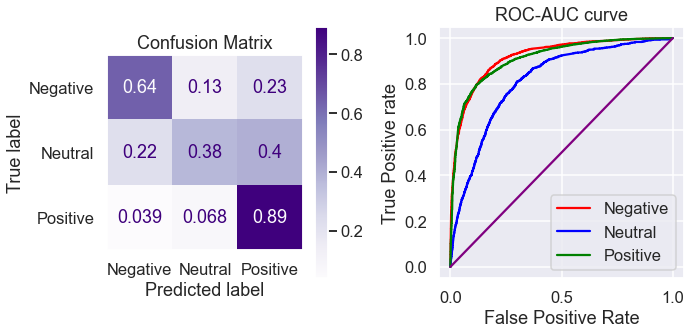

In [78]:
# Evaluate best model performance
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, 
               gridsearch.best_estimator_)

We do see some improvement in the model's ability to correctly predict neutral sentiment, but this comes at the cost of our negative and positive sentiment recall scores. Hence, we conclude that the Logistic Regression algorithm is a much better choices than the Random Forest algorithm for our task.

## Binary Modeling: [1-3] Negative,  [4-5] Positive

Here, we return to our binary classification problem where ratings of 1-3 stars will be considered to be negative, and 4-5 star ratings will be considered to be positive.

### Vectorizing Train-Test Splits

Similar to the multi-class modeling problem, we will vectorize the data following its new train-test split.

In [79]:
# Make y
y_bin = clean_df['sent_bin_4up'].copy()

## Train Test Split
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, 
                                                                    test_size=0.3, 
                                                                    random_state=27)

# Check y_train value counts
y_bin_train.value_counts(normalize=True)

1    0.77493
0    0.22507
Name: sent_bin_4up, dtype: float64

In [80]:
# Make a TF-IDF vectorizer using previously created tokenizer
vectorizer_bin = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                                 token_pattern=r"([a-zA-Z]+(?:’[a-z]+)?)",
                                 stop_words=stopwords_list,
                                 ngram_range=(1,2))

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_bin_train_tfidf = vectorizer_bin.fit_transform(X_bin_train)
X_bin_test_tfidf = vectorizer_bin.transform(X_bin_test)
X_bin_train_tfidf

<31288x310249 sparse matrix of type '<class 'numpy.float64'>'
	with 1030078 stored elements in Compressed Sparse Row format>

### Logistic Regression
Again, let's start modeling for our binary classification problem with Logistic Regression.

In [81]:
# Fit Logistic Regression model on binary training data
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_bin_train_tfidf, y_bin_train)

LogisticRegression(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 0.94 
 Test Score: 0.89 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3064
           1       0.96      0.90      0.93     10346

    accuracy                           0.89     13410
   macro avg       0.84      0.88      0.86     13410
weighted avg       0.90      0.89      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


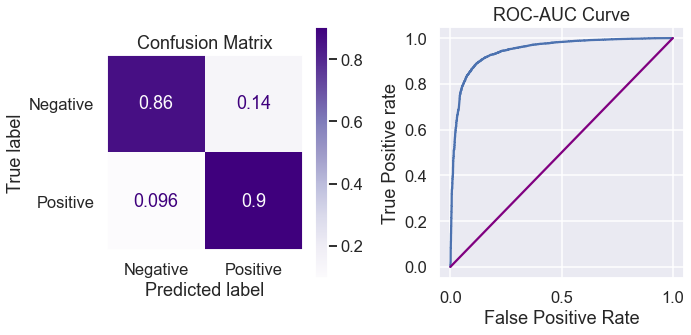

In [82]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, logreg, 2)

Right off the bat, we see great performance with our Logistic Regression algorithm. Again, due to hardware limitations we will not gridsearch this model. Although the model does seem to be slightly overfitting to the training data, it is not overfitting by a large amount. We can see that our F1 score is 0.86 for negative classification and .90 for positive classification, which is quite good.

### Random Forest

In [83]:
# Fit Random Forest model on binary training data
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_bin_train_tfidf, y_bin_train)

RandomForestClassifier(class_weight='balanced')

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.88 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.88      0.54      0.67      3064
           1       0.88      0.98      0.93     10346

    accuracy                           0.88     13410
   macro avg       0.88      0.76      0.80     13410
weighted avg       0.88      0.88      0.87     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


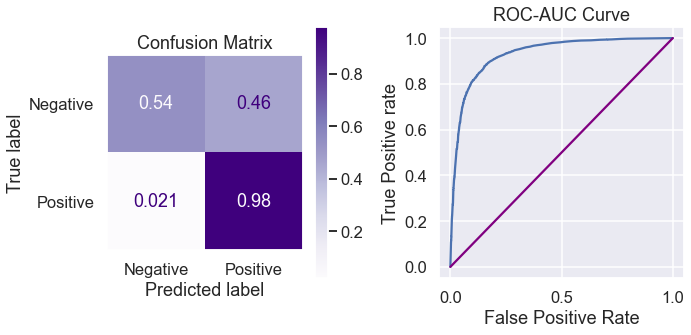

In [84]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, rf, 2)

Because we haven't altered any of the hyperparameters for our Random Forest algorithm, we again see that our modelling is clearly overfitting to the training data. Let's run a few gridsearches on this model.

In [85]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [10, 20, 30, 40],
              'min_samples_leaf': [3, 5, 7]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 3}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.87 
 Test Score: 0.87 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      3064
           1       0.91      0.92      0.91     10346

    accuracy                           0.87     13410
   macro avg       0.81      0.81      0.81     13410
weighted avg       0.86      0.87      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


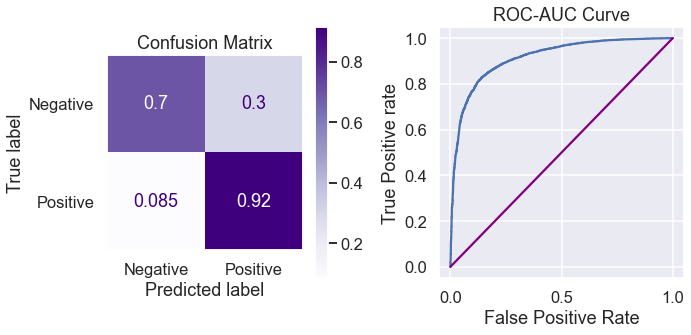

In [86]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

Great! We have addressed the issue of overfitting. Our model is performing much better on the negative classification, and only a little worse on the positive classification. Let's see if we can further improve our gridsearch performance.

In [87]:
# Initialize Random Forest algorithm
rf = RandomForestClassifier(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'criterion': ['entropy'], 
              'max_depth': [40, 50, 60],
              'min_samples_leaf': [1, 2, 3]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=rf, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 60, 'min_samples_leaf': 1}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.88 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      3064
           1       0.90      0.95      0.93     10346

    accuracy                           0.88     13410
   macro avg       0.85      0.80      0.82     13410
weighted avg       0.88      0.88      0.88     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


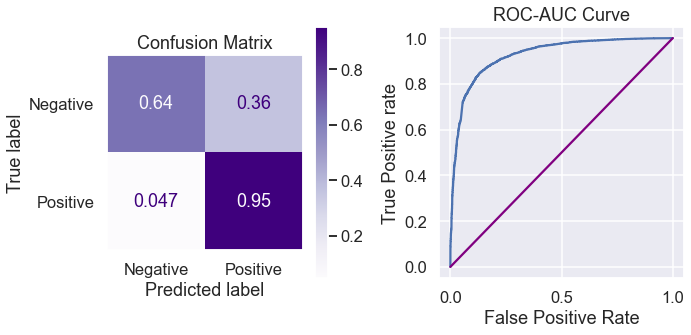

In [88]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

Again, we can see that we are already overfitting to the training data again, and the model's overall performance is already getting worse.

### Support Vector Classification

Because our vectorized bag of words has a muc hhigher number of columns than rows, we can expect our Suppoer Vector Classification model to performan well.

In [89]:
# Fit SVC model on binary training data
svc = LinearSVC()
svc.fit(X_bin_train_tfidf, y_bin_train)

LinearSVC()

****TRAIN VS TEST ACCURACY****

 Training Score: 1.0 
 Test Score: 0.91 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3064
           1       0.93      0.95      0.94     10346

    accuracy                           0.91     13410
   macro avg       0.87      0.86      0.87     13410
weighted avg       0.91      0.91      0.91     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


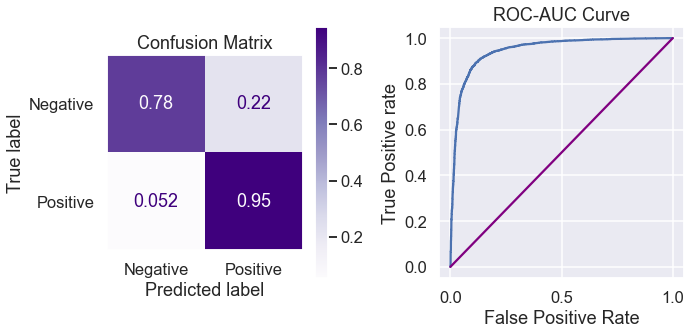

In [90]:
# Evaluate model performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, svc, 2)

Without altering the model's hyperparameters, we can already see decent performance, with positive classification performing slightly better than our Logistic Regression, and negative classification doing slightly worse. Let's use a gridsearch to see if we can improve the model's performance.

In [91]:
# Initialize SVC algorithm
svc = LinearSVC(class_weight='balanced')

# Create hyperparameter grid to gridsearch
param_grid = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'tol': [0.000001, 0.0001, 0.01],
              'C': [0.1, 1, 10], 
              'fit_intercept': [True, False]}

# Initialize gridsearch optimized for F1 macro score
gridsearch = GridSearchCV(estimator=svc, param_grid = param_grid, 
                          scoring='f1_macro', n_jobs=-1)

# Run gridsearch and display best hyperparameters
gridsearch.fit(X_bin_train_tfidf,  y_bin_train)
gridsearch.best_params_

{'C': 1, 'fit_intercept': True, 'loss': 'hinge', 'penalty': 'l2', 'tol': 1e-06}

****TRAIN VS TEST ACCURACY****

 Training Score: 0.98 
 Test Score: 0.9 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      3064
           1       0.95      0.92      0.94     10346

    accuracy                           0.90     13410
   macro avg       0.85      0.88      0.87     13410
weighted avg       0.91      0.90      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


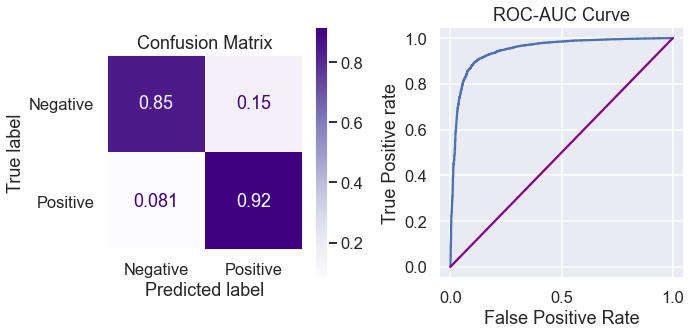

In [92]:
# Evaluate best model's performance
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, 
               gridsearch.best_estimator_, 2)

# iNTERPRET

Now that we're done modeling, we can move on to interpreting the results. Below, we can see a summary of our best performing models, which were the Logistic Regression for multi-class sentiments, and Logistic Regression for binary sentiments. Out of the two models, our multi-class model had poorer performance, and so we will only be using that as reference to support any findings from the best model. Although our SVC model did have a slightly better F1 macro score, we will focus on the Logistic Regression model due to its more even predictive capability between negative and positive sentiments and also for ease of interpretation.

### Best Model Summary

By observing the evaluation metrics from each of our models, we can see that the binary classification models had much better performance. We will still examine the feature coefficients found in our Multi-Class Logistic Regression as a reference point, but for extracting final insights, we will make use of our Binary Logistic Regression and SVC models. Below, we can find a roundup of each model's performance metrics along with their fit times.

#### Multi-Class Logistic Regression

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
****TRAIN VS TEST ACCURACY****

 Training Score: 0.95 
 Test Score: 0.85 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      2347
           1       0.23      0.39      0.29       717
           2       0.96      0.89      0.92     10346

    accuracy                           0.85     13410
   macro avg       0.64      0.69      0.66     13410
weighted avg       0.88      0.85      0.86     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


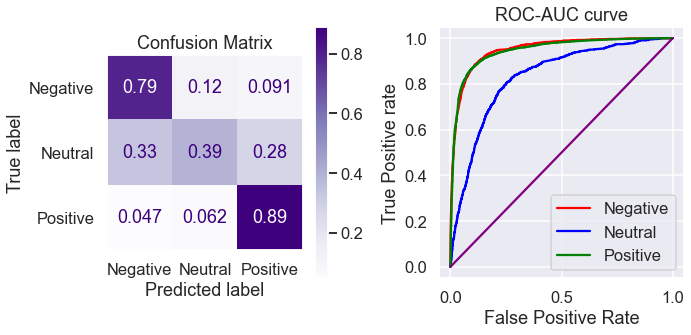

In [93]:
# Fit best performing Logistic Regression on multi-class data
# and display performance
%time
best_multi_lr = LogisticRegression(max_iter=200, class_weight='balanced')
best_multi_lr.fit(X_multi_train_tfidf, y_multi_train)
evaluate_model(y_multi_test, y_multi_train, 
               X_multi_test_tfidf, X_multi_train_tfidf, best_multi_lr)

#### Binary Logistic Regression

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
****TRAIN VS TEST ACCURACY****

 Training Score: 0.94 
 Test Score: 0.89 

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3064
           1       0.96      0.90      0.93     10346

    accuracy                           0.89     13410
   macro avg       0.84      0.88      0.86     13410
weighted avg       0.90      0.89      0.90     13410

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


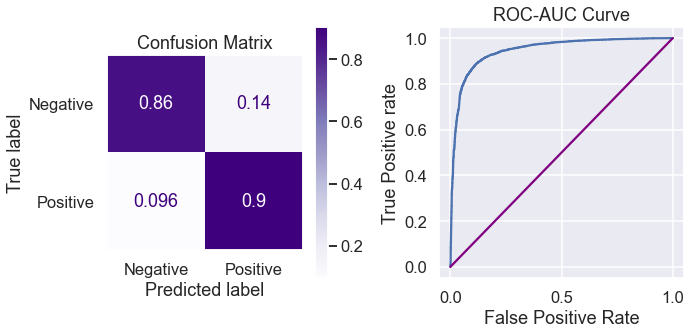

In [94]:
# Fit best performing Logistic Regression on binary data
# and display performance
%time
best_bin_lr = LogisticRegression(class_weight='balanced')
best_bin_lr.fit(X_bin_train_tfidf, y_bin_train)
evaluate_model(y_bin_test, y_bin_train, 
               X_bin_test_tfidf, X_bin_train_tfidf, best_bin_lr, 2)

We can see that there is a small difference in training times between these models.

### Evaluating Feature Importances to Sentiment Classification

Here, we provide a summary of visualizations that can help us determine what words are indicative of either positive or negative sentiments. We first revisit our wordclouds to remind ourselves what words are frequently found in negative and positive sentiments, then move on to examine feature coefficients from our Logistic Regression models.

##### Revisiting Multi-Class WordClouds

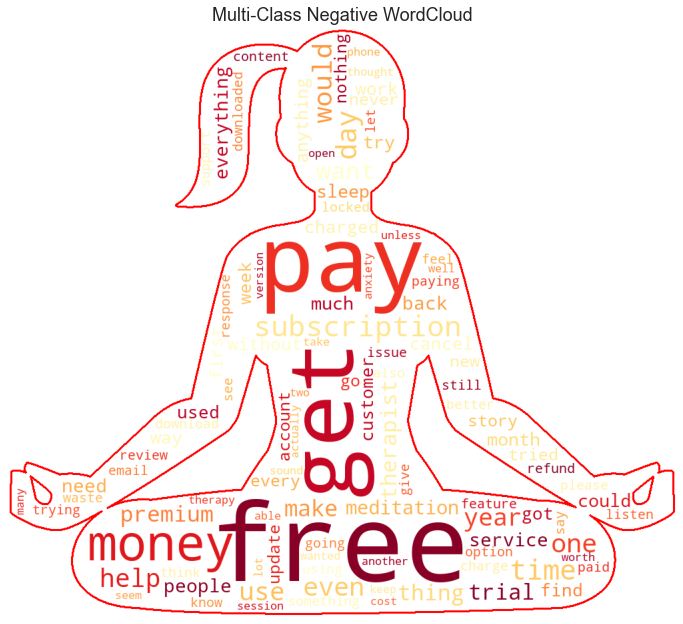

In [95]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(multi_neg_wc) 
plt.title('Multi-Class Negative WordCloud')
plt.axis('off');

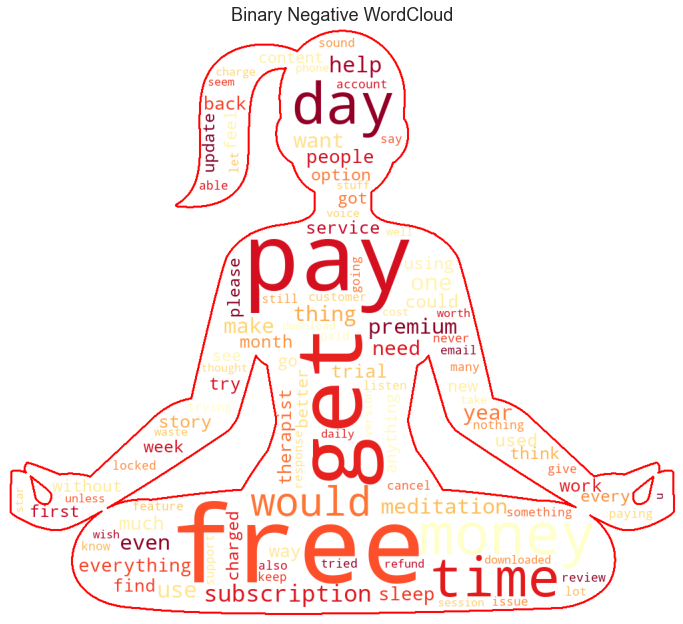

In [96]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(bin_neg_wc) 
plt.title('Binary Negative WordCloud')
plt.axis('off');

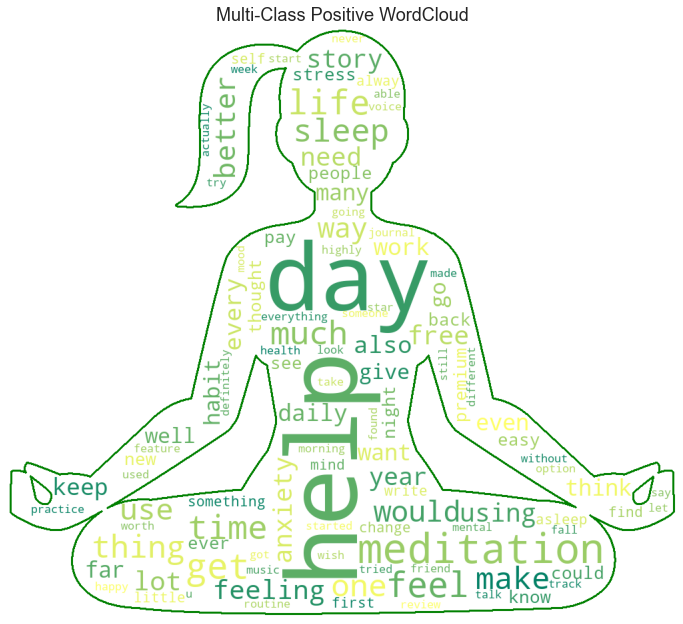

In [97]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(multi_pos_wc) 
plt.title('Multi-Class Positive WordCloud')
plt.axis('off');

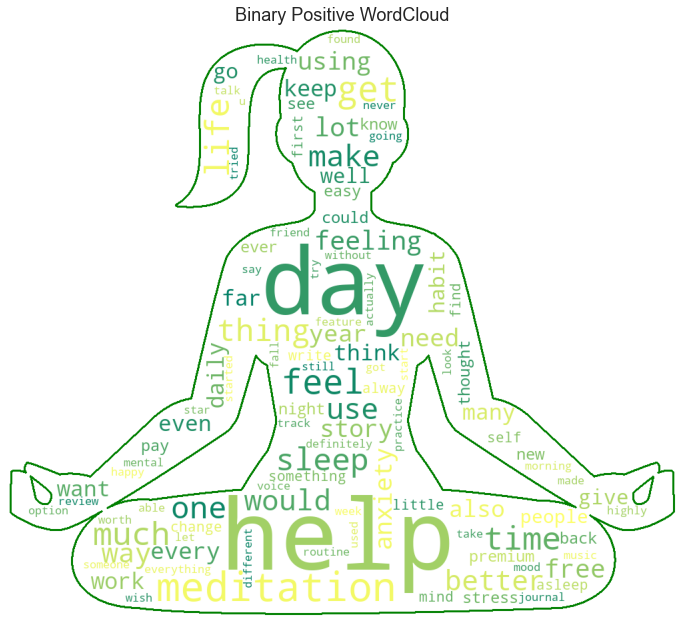

In [98]:
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(bin_pos_wc) 
plt.title('Binary Positive WordCloud')
plt.axis('off');

#### Model Feature Coefficient Analysis

Now let's compare how the insights from our models compare to these wordclouds.

In order to easily visualize what words had a heavier impact on the classification tasks, we will create barplots of the feature coefficients. For Logistic Regression, our units are in log odds, and so we can use the resulting visuals to get an idea of how much importance certain words relative to other words.

##### Extracting Coefficients

In [99]:
# Extract coefficients for negative classification from multi-class LogReg model
feature_names_multi = vectorizer_multi.get_feature_names()
log_coeff_multi = pd.Series(best_multi_lr.coef_[0], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_neg = log_coeff_multi.head(30)
lr_multi_neg

waste           4.149088
pay             3.930401
scam            3.911700
refund          3.752736
nothing         3.589443
useless         3.360529
money           3.357976
cancel          3.322177
charged         3.271018
free            3.228345
paid            3.165171
youtube         3.060643
deleted         3.060080
even            2.959672
anything        2.938652
response        2.908503
charge          2.851537
service         2.808596
trial           2.759657
can’t           2.556559
used            2.437097
unless          2.404335
downloaded      2.376491
subscription    2.364908
waste time      2.360954
another         2.343165
account         2.250450
support         2.167510
ridiculous      2.138987
tried           2.107287
dtype: float64

In [100]:
# Extract coefficients for neutral classification from multi-class LogReg model
log_coeff_multi = pd.Series(best_multi_lr.coef_[1], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_neut = log_coeff_multi.head(30)
lr_multi_neut

wish             3.306832
however          3.296086
needs            3.156431
okay             2.619824
pay              2.542509
locked           2.497298
update           2.487984
things           2.481749
it’s ok          2.349625
doesn’t          2.262670
notifications    2.238217
ok               2.211682
please           2.204475
premium          2.168191
three stars      2.163153
three            2.141338
meh              2.141167
could better     2.109335
though           2.084982
alright          2.053412
sometimes        2.012195
it’s calming     2.008919
mostly           1.985532
think            1.960752
rest             1.955075
distracting      1.944241
ss               1.922132
joann            1.922132
fatima           1.905458
coaching         1.892594
dtype: float64

In [101]:
# Extract coefficients for positive classification from multi-class LogReg model
log_coeff_multi = pd.Series(best_multi_lr.coef_[2], 
                            index=feature_names_multi).sort_values(ascending=False)
lr_multi_pos = log_coeff_multi.head(30)
lr_multi_pos

life          4.564987
easy          3.136781
highly        3.133140
day           2.680304
mind          2.511738
feel          2.323330
definitely    2.298280
far           2.192939
lot           2.190680
didn’t pay    2.135592
ever          2.050639
truly         2.039540
grateful      2.026560
absolutely    1.929679
anxiety       1.907714
feelings      1.875360
friend        1.843545
meditation    1.818306
everyday      1.795276
i’ve          1.792564
practice      1.752999
feeling       1.727808
asleep        1.726594
happy         1.698626
gives         1.682562
night         1.649463
fun           1.619550
diary         1.610030
positive      1.570776
relaxed       1.561558
dtype: float64

In [102]:
# Extract coefficients for positive classification from binary LogReg model
feature_names_bin = vectorizer_bin.get_feature_names()
log_coeff_bin = pd.Series(best_bin_lr.coef_.flatten(), 
                          index=feature_names_bin).sort_values(ascending=False)
lr_bin_pos = log_coeff_bin.head(22)
lr_bin_pos

life          6.675193
easy          4.320892
highly        4.144591
day           4.031501
feel          3.533113
far           3.494255
definitely    3.296762
mind          3.275490
lot           3.157402
feelings      2.989367
grateful      2.850748
truly         2.838214
meditation    2.760275
didn’t pay    2.700208
i’ve          2.595948
feeling       2.559657
asleep        2.510027
everyday      2.506764
anxiety       2.504001
friend        2.476129
habits        2.455346
night         2.428035
dtype: float64

In [103]:
# Extract coefficients for negative classification from binary LogReg model
lr_bin_neg = log_coeff_bin.tail(22)
lr_bin_neg

refund         -4.147979
paying         -4.158967
useless        -4.185140
charge         -4.238370
service        -4.249729
frustrating    -4.288553
scam           -4.348352
waste          -4.404109
crashes        -4.414699
trial          -4.461804
cancel         -4.746034
subscription   -4.789707
nothing        -5.263785
can’t          -5.267615
deleted        -5.293287
doesn’t        -5.322337
update         -5.366532
locked         -5.800127
charged        -5.837720
free           -6.670681
money          -7.534205
pay            -9.175482
dtype: float64

##### Multi-Class Logistic Regression Coefficients

In [104]:
# Create function to create barplots using feature coefficients
def barplot_series(series, title, xlabel, ylabel, palette='cool'):
    """
    Displays barplot of input series.
    
    If the argument 'params' is passed, will display a table of the 
    parameters hyperparameters used in the model.

    Args:
        series (Series) : Series containing data to visualize.
        title (str) : Title of plot.
        xlabel (str) : X axis title.
        ylabel (str) : y axis title.
        palette : Color palette to create plot using.
        
    Returns:
    
    """
    # Create bar plot of feature coefficients as odds.
    fig, ax = plt.subplots(figsize=(10,10))

    sns.barplot(x=series.values, y=series.index, palette=palette, 
              ax=ax, orient='h')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

In [105]:
# Set Seaborn style
sns.set_style('darkgrid')

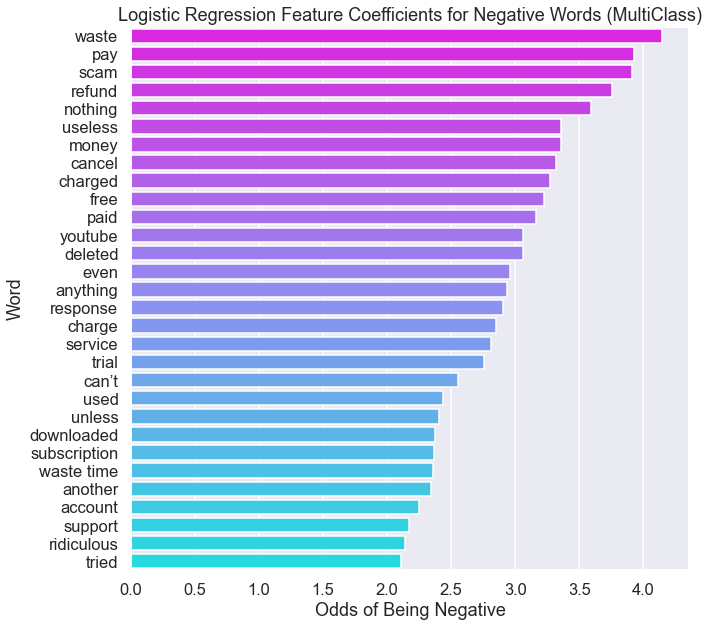

In [106]:
# Create bar plot of feature coefficients for multiclass negative as log odds
barplot_series(lr_multi_neg, 
               "Logistic Regression Feature Coefficients for Negative Words (MultiClass)", 
               "Odds of Being Negative", "Word", palette='cool_r')

Our Multi-Class negative sentiment coefficients indicate with words such as "pay", "money", "charged", "free", "charge" and "subscription" that users are mostly unhappy about the costs that are involved in using the app. We can also see from words including "scam", "refund", "cancel", "service", "account" and "support" that it is likely that a lot of negative reviews are related to customer support.

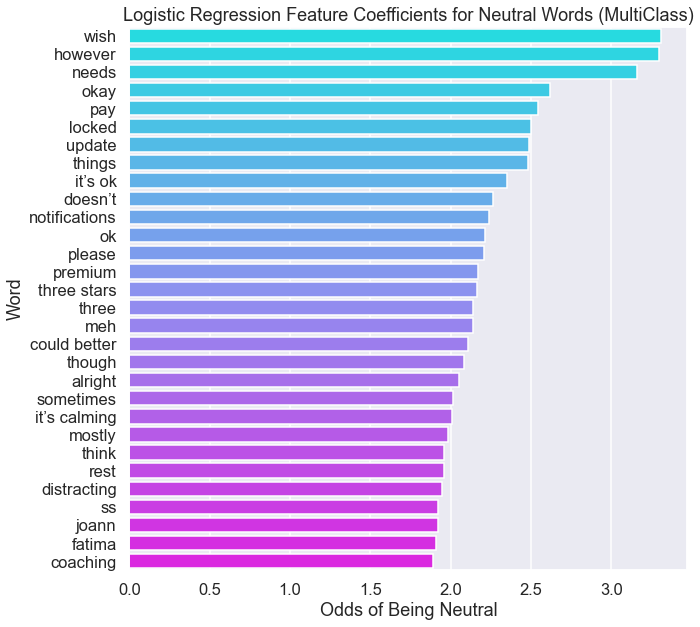

In [107]:
# Create bar plot of feature coefficients for multiclass neutral as log odds
barplot_series(lr_multi_neut, 
               "Logistic Regression Feature Coefficients for Neutral Words (MultiClass)", 
               "Odds of Being Neutral", "Word")

We can see that our model seems to have extracted words that indeed indicate what topics are related to a neutral review. However, this information is not so crucial to our analysis.

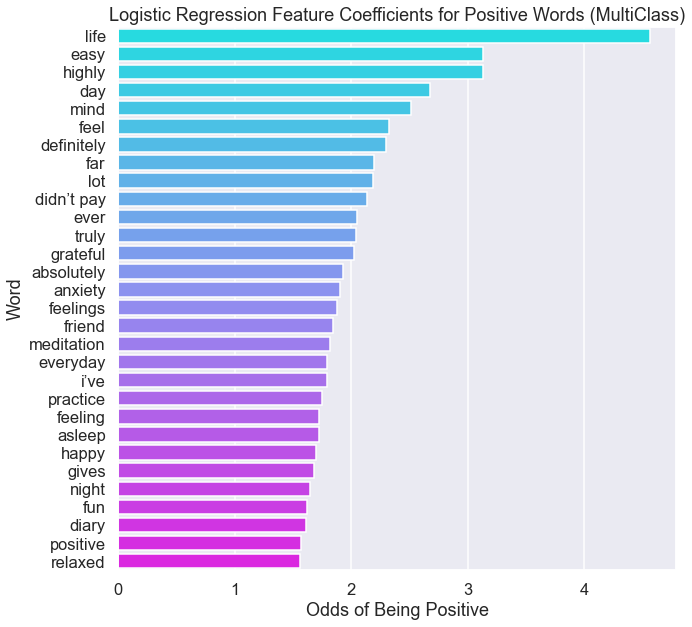

In [108]:
# Create bar plot of feature coefficients for multiclass positive as log odds
barplot_series(lr_multi_pos, 
               "Logistic Regression Feature Coefficients for Positive Words (MultiClass)", 
               "Odds of Being Positive", "Word")

For multi-class positive classification, we can see from the words "asleep" and "night" that sleep functionality is considered a positive element of the app. We also see from the words "easy", "day", "everyday" and "diary" that users appreciate ease of use that enables people to use the app regularly.

Now that we have a general idea of what words are associated with negative and positive sentiments, let's move on to examine whether our binary classification model confirms our findings.

##### Binary Logistic Regression Coefficients


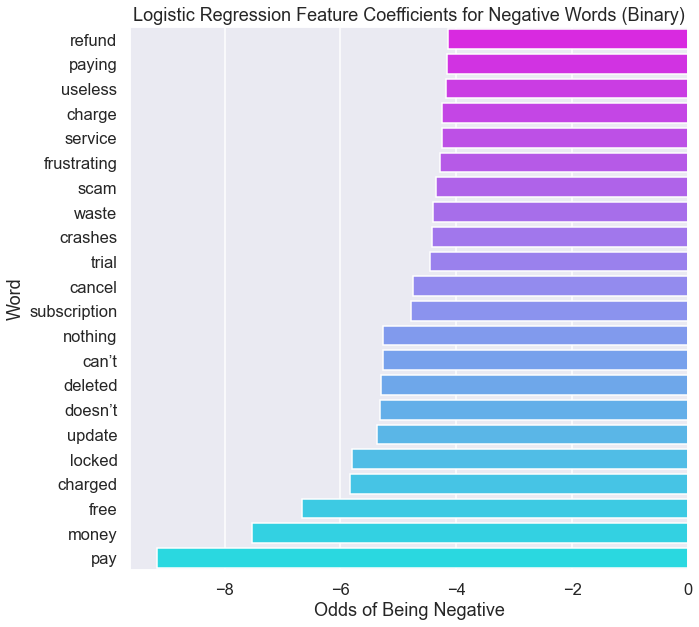

In [109]:
# Create bar plot of feature coefficients for binary negative as log odds
barplot_series(lr_bin_neg, 
               "Logistic Regression Feature Coefficients for Negative Words (Binary)", 
               "Odds of Being Negative", "Word", 'cool_r')

Our binary Logistic Regression confirms that payment is a major issue, and through the words "response" and "crashes" further reinforces that customer support is also something to consider while addressing negative reviews.

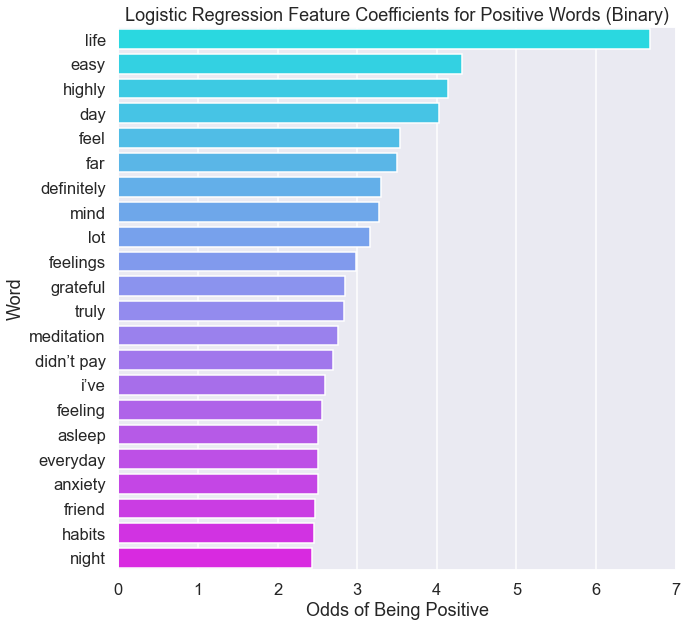

In [110]:
# Create bar plot of feature coefficients for binary positive as log odds
barplot_series(lr_bin_pos, 
               "Logistic Regression Feature Coefficients for Positive Words (Binary)", 
               "Odds of Being Positive", "Word")

For positive sentiments, we see another key indicator word "habits" which further illustrates that users appreciate being able to make the app a regular part of their routine. We also see the words "night" and "asleep", which confirm that sleep functionality is considered a highly positive app feature.

#### Local Interpretable Model-agnostic Explanations (LIME)

Finally, let's use the LIME package to help us better understand exactly how our binary Logistic Regression model is breaking down each review in the process of determining whether it is positive or negative.

In [111]:
# Write function to display LIME text explainer visualizations
def explain_text(idx):
    """
    Creates LIME explainer visualization for a specified review text.

    Args:
        idx (int) : Index number of review text.
        
    Returns:
    
    """
    c = make_pipeline(vectorizer_bin, best_bin_lr)
    class_names=['Negative', 'Positive']
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(X_bin_test[idx], c.predict_proba, 
                                   num_features=6)
    print('Document id: %d' % idx)
    print('Probability(Positive) =', c.predict_proba([X_bin_test[idx]])[0,1])
    print('True class: %s' % class_names[y_bin_test[idx]])
    exp.show_in_notebook(text=True)

In [112]:
# Explain negative review
explain_text(17187)

Document id: 17187
Probability(Positive) = 0.020999261127576607
True class: Negative


In the above example, we can see that this user is unhappy with how he/she has been charged. This again points to the idea that we need to carefully consider how the user should be charged for the app, as well as what kind of support to provide to address this type of issue.

In [113]:
# Explain positive review
explain_text(4721)

Document id: 4721
Probability(Positive) = 0.9423697140038891
True class: Positive


In this positive example, we can see that there are some words such as "pain", "restlessness" and "struggle" that seem negative. However, our model has determined that there are other words that have higher importance, including "mind", "sleeping", "forward" and "asleep" that carry much more weight in classifying this review as a positive one.

Now, let's take a look at a review that our model was unable to predict correctly.

In [114]:
# Explain incorrect classification
explain_text(3212)

Document id: 3212
Probability(Positive) = 0.5265458013611568
True class: Negative


When we look at the text, it is obvious to us that the word "stupid" is an indicator of negative sentiment, but our trained model was unable to pick up on this word. Although it correctly determined that the words "free" and "premium" indicate a negative sentiment, our model also considers any mention of "fall" and "asleep" to be positive. The prediction probabilities indicate that the model was unable to easily determine that this was a negative review. This example shows us that although our model might make occasional errors in correctly predicting the overall sentiment, it does give us a good idea of what words and topics are considered positive or negative.

# CONCLUSIONS & RECOMMENDATIONS

Now that we have thoroughly analyzed the EDA and models of mental health app reviews and ratings throughout the course of this notebook, we can return to the questions outlined in the Business Problem phase, which are:

> 1. What do users like or dislike about apps currently available on the iTunes App Store?
> 2. How can we use this information to develop a strategy for building a new mental health app that can compete with apps that have already seen success?

First, we now know that the following topics are highly correlated with negative sentiment:
> - Payment and costs
> - Technical and customer support

These topics are considered highly associated with positive sentiment:
> - Sleep-aid functionality
> - Ease-of-use and regular use

Using these insights, we now have an idea of what elements to focus on when building a new mental health app to compete with other apps already on the market. My recommendations are as follows:
> 1. Since payment and costs seem to be a prevalent issue in negative reviews, app pricing and subscription fees needs to be well thought-out. Many reviews mentioned dissastisfaction in the "free" aspect of the app, indicating that they may have felt misled. We should address this issue by specifying at the time of download about what features of the app are free and what features are reserved for premium members. 
> 2. Allocate sufficient resources toward thoroughly training the customer support team. Users expressed dissastisfaction in when their app crashed, as well as not having their payment issues properly resolved. We should make sure that customer support is trained to proficiently diagnose any technical issues as well as any payment-related issues users might experience.
> 3. Invest in R&D of the sleep-aid functionality of the app. Users associated sleep-related words with positive sentiment, and this illustrates that an app's ability to become an effective sleeping aid can be a determinant factor of its overall effect on the user's mental health.
> 4. Thoroughly develop the interface of the app to make it pleasant and easy to use. Users are likely to associate ease-of-use and the ability to make using the app a regular habit with positive sentiment, so the UI/UX designers will want to address this accordingly.

Some limitations and ideas for further analysis include:
> - We currently do not have any pricing data of apps. Further research and analysis could be done regarding pricing of subscription and app costs to determine what the best pricing scheme would be.
> - Our data is currently limited to the reviews and ratings on the Apple App Store. Collecting and analyzing app reviews from the Google Play Store to examine how they compare would help us get a well-rounded idea of the sentiments of all mobile app users, as opposed to just Apple users.
> - Possible implementation of Latent Dirichlet Allocation topic modeling to extract deeper insights on what topics could be found in negative vs positive reviews.